# Phân Tích Khám Phá Dữ Liệu (EDA) - Dự Đoán Doanh Thu Phim

---

## Thông Tin Dự Án

**Tên dự án:** Movie Revenue Prediction  
**Môn học:** Python cho Khoa học Dữ liệu - K23  
**Loại bài toán:** Regression (Hồi quy)  
**Nguồn dữ liệu:** TMDb API (The Movie Database)  
**Thời gian:** Phim phát hành từ 2020-2024

---

## Mục Tiêu của Notebook

Notebook này thực hiện phân tích khám phá dữ liệu (Exploratory Data Analysis - EDA) trên tập dữ liệu phim thô, nhằm:

1. **Đánh giá chất lượng dữ liệu:** Xác định missing values, outliers, và các vấn đề về data quality
2. **Khám phá phân phối các biến:** Hiểu rõ đặc điểm của từng feature riêng lẻ
3. **Phân tích mối quan hệ:** Tìm ra correlations giữa các features và target variable (revenue)
4. **Rút ra insights:** Xác định patterns và insights quan trọng để hướng dẫn preprocessing và modeling
5. **Trực quan hóa:** Tạo các biểu đồ chất lượng cao phục vụ báo cáo

---

## Cấu Trúc Notebook

1. **Introduction & Setup** - Thiết lập môi trường và load dữ liệu
2. **Data Quality Assessment** - Đánh giá chất lượng dữ liệu
3. **Univariate Analysis** - Phân tích từng biến riêng lẻ
4. **Bivariate Analysis** - Phân tích mối quan hệ giữa các biến
5. **Text Analysis** - Phân tích dữ liệu text (overview)
6. **Multivariate & Special Analysis** - ROI và Production Companies
7. **Key Insights & Recommendations** - Tổng kết và khuyến nghị

---

# 1. INTRODUCTION & SETUP

Phần này thiết lập môi trường làm việc, import các thư viện cần thiết, và load dữ liệu thô từ file CSV.

## 1.1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
from collections import Counter
import re

# Statistics
from scipy import stats
from scipy.stats import skew, kurtosis

# Utilities
import warnings
from pathlib import Path

# Cấu hình
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# Matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1.2. Helper Functions

In [2]:
def save_and_show_plot(filename, dpi=300):
    """
    Hàm tiện ích để tự động lưu và hiển thị plot.
    
    Args:
        filename (str): Tên file (không cần extension)
        dpi (int): Độ phân giải ảnh
    """
    # Tạo thư mục nếu chưa tồn tại
    save_dir = Path('visualizations/eda_plots')
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Lưu plot
    filepath = save_dir / f"{filename}.png"
    plt.savefig(filepath, dpi=dpi, bbox_inches='tight', facecolor='white')
    print(f"Đã lưu plot: {filepath}")
    
    # Hiển thị
    plt.show()
    
    # Đóng figure để tránh memory leak
    plt.close()

def format_currency(value):
    """
    Format số thành dạng currency (USD).
    
    Args:
        value (float): Giá trị cần format
    
    Returns:
        str: Chuỗi đã format
    """
    if value >= 1e9:
        return f"${value/1e9:.2f}B"
    elif value >= 1e6:
        return f"${value/1e6:.2f}M"
    elif value >= 1e3:
        return f"${value/1e3:.2f}K"
    else:
        return f"${value:.2f}"

def print_section_header(title):
    """
    In header đẹp cho mỗi section.
    
    Args:
        title (str): Tiêu đề section
    """
    print("\n" + "-"*80)
    print(f"  {title}")
    print("-"*80 + "\n")

print("Đã định nghĩa helper functions")

Đã định nghĩa helper functions


## 1.3. Load Data

In [4]:
# Đọc dữ liệu từ file CSV
data_path = '../data/raw/movies_2020_2024.csv'

try:
    df = pd.read_csv(data_path)
    print(f"Đã load thành công dữ liệu từ: {data_path}")
    print(f"\nKích thước dataset: {df.shape[0]:,} hàng × {df.shape[1]} cột")
except FileNotFoundError:
    print(f"Không tìm thấy file: {data_path}")
    print("Vui lòng đảm bảo đã chạy data fetching script trước.")

Đã load thành công dữ liệu từ: ../data/raw/movies_2020_2024.csv

Kích thước dataset: 623 hàng × 14 cột


## 1.4. Quick Overview

In [5]:
# Hiển thị 5 dòng đầu tiên
print_section_header("QUICK DATA PREVIEW")
display(df.head())


--------------------------------------------------------------------------------
  QUICK DATA PREVIEW
--------------------------------------------------------------------------------



,id,title,budget,revenue,runtime,release_date,vote_average,vote_count,popularity,overview,genres,production_companies,original_language,status
0,38700,Bad Boys for Life,90000000,426505244,124,2020-01-15,7.13,8553,8.02,Marcus and Mike are forced to confront new thr...,Thriller|Action|Crime,Columbia Pictures|2.0 Entertainment|Don Simpso...,en,Released
1,577922,Tenet,205000000,365304105,150,2020-08-22,7.20,10634,6.20,Armed with only one word - Tenet - and fightin...,Action|Thriller|Science Fiction,Warner Bros. Pictures|Syncopy,en,Released
2,454626,Sonic the Hedgehog,85000000,319715683,99,2020-02-12,7.30,10152,8.94,"Powered with incredible speed, Sonic The Hedge...",Action|Science Fiction|Comedy|Family,Original Film|Blur Studio|Marza Animation Plan...,en,Released
3,448119,Dolittle,175000000,251410631,101,2020-01-02,6.59,3770,7.82,"After losing his wife seven years earlier, the...",Family|Comedy|Fantasy|Adventure,Universal Pictures|Team Downey|Perfect World P...,en,Released
4,529203,The Croods: A New Age,65000000,215905815,95,2020-11-25,7.50,4016,6.92,"Searching for a safer habitat, the prehistoric...",Animation|Family|Adventure|Fantasy|Comedy,DreamWorks Animation,en,Released


In [6]:
# Thông tin tổng quan về dataset
print_section_header("DATASET INFORMATION")
df.info()


--------------------------------------------------------------------------------
  DATASET INFORMATION
--------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    623 non-null    int64  
 1   title                 623 non-null    object 
 2   budget                623 non-null    int64  
 3   revenue               623 non-null    int64  
 4   runtime               623 non-null    int64  
 5   release_date          623 non-null    object 
 6   vote_average          623 non-null    float64
 7   vote_count            623 non-null    int64  
 8   popularity            623 non-null    float64
 9   overview              623 non-null    object 
 10  genres                621 non-null    object 
 11  production_companies  620 non-null    obj

In [7]:
# Danh sách các cột
print_section_header("COLUMNS IN DATASET")
print("Tổng số cột:", len(df.columns))
print("\nDanh sách cột:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col:30s} - {df[col].dtype}")


--------------------------------------------------------------------------------
  COLUMNS IN DATASET
--------------------------------------------------------------------------------

Tổng số cột: 14

Danh sách cột:
 1. id                             - int64
 2. title                          - object
 3. budget                         - int64
 4. revenue                        - int64
 5. runtime                        - int64
 6. release_date                   - object
 7. vote_average                   - float64
 8. vote_count                     - int64
 9. popularity                     - float64
10. overview                       - object
11. genres                         - object
12. production_companies           - object
13. original_language              - object
14. status                         - object


| Tên Biến               | Kiểu Dữ liệu | Mô tả                                                          |   
| :--------------------- | :----------- | :-------------------------------------------------------------|
| `id`                   | `int64`      | Mã định danh duy nhất của phim trên hệ thống TMDb. Đây là khóa chính, không trùng lặp giữa các bản ghi.            |              
| `title`                | `object`     | Tên gốc của bộ phim (thường là Tiếng Anh).                     |              
| `budget`               | `int64`      | Ngân sách sản xuất phim (đơn vị: USD).                         |             
| `revenue`              | `int64`      | Doanh thu phòng vé toàn cầu (đơn vị: USD) – **Biến mục tiêu**. |              
| `runtime`              | `int64`      | Thời lượng phim (đơn vị: phút).                                |              
| `release_date`         | `object`     | Ngày công chiếu phim (định dạng chuỗi: `YYYY-MM-DD`). Có thể cần chuyển sang datetime.         |              
| `vote_average`         | `float64`    | Điểm đánh giá trung bình trên thang 10.                        |              
| `vote_count`           | `int64`      | Tổng số lượng lượt đánh giá (votes). Giá trị có thể dao động mạnh (vài trăm đến hàng chục nghìn).                          |              
| `popularity`           | `float64`    | Chỉ số phổ biến của phim (tính toán bởi thuật toán TMDb).      |              
| `overview`             | `object`     | Tóm tắt nội dung phim (văn bản tự do).                         |              
| `genres`               | `object`     | Danh sách thể loại phim, lưu dưới dạng chuỗi phân tắng bằng dấu \||
| `production_companies` | `object`     | Danh sách công ty sản xuất.                       |              
| `original_language`    | `object`     | Mã ngôn ngữ gốc của phim (ví dụ: `en`, `vi`).                  |              
| `status`               | `object`     | Trạng thái phát hành (ví dụ: `Released`).                      |              


### Nhận xét ban đầu:

Dataset cung cấp thông tin chi tiết về các bộ phim phát hành trong giai đoạn gần đây (2020–2024), bao gồm cả dữ liệu số, dữ liệu phân loại và dữ liệu dạng văn bản. Một số điểm nổi bật:

### **1. Về cấu trúc dữ liệu**

Dataset bao gồm nhiều loại biến khác nhau:

* **Numeric features:** `budget`, `revenue`, `runtime`, `vote_average`, `vote_count`, `popularity`
  → Thích hợp cho các mô hình hồi quy.

* **Categorical features:** `genres`, `production_companies`, `original_language`, `status`
  → Một số biến (như `genres`, `production_companies`) là **multi-label** lưu dạng chuỗi phân tách bằng dấu `|`, cần xử lý đặc biệt trước khi modeling.

* **Text feature:** `overview`
  → Có thể sử dụng cho NLP hoặc trích xuất thông tin bổ sung (keywords, sentiment…).

* **Date feature:** `release_date`
  → Có thể tách thành `year`, `month`, `quarter` để tăng tính predictive.

### **2. Về biến mục tiêu (Target Variable)**

* **`revenue`** là biến target cho bài toán dự đoán.
* Giá trị dao động từ mức vài triệu đến hơn **1 tỷ USD**, phân phối **rất lệch (highly skewed)**.
  → Có thể cần log-transform (`log1p`) để mô hình hoạt động tốt hơn.

### **3. Về chất lượng dữ liệu (Data Quality)**

* Cần kiểm tra **missing values**, đặc biệt ở các cột văn bản và categorical.
* Nên kiểm tra **outliers** ở `budget`, `revenue`, `runtime`, `popularity` vì các biến này dễ có giá trị bất thường.
* Hai trường đa nhãn (`genres`, `production_companies`) cần được xử lý split/encode trước khi đưa vào model.

---

# 2. DATA QUALITY ASSESSMENT

Phần này đánh giá chi tiết chất lượng dữ liệu, bao gồm missing values, data types, và basic statistics.

## 2.1. Missing Values Analysis

In [8]:
# Tính toán missing values
print_section_header("MISSING VALUES ANALYSIS")

missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})

# Chỉ hiển thị các cột có missing values
missing_data = missing_data[missing_data['Missing_Count'] > 0]
missing_data = missing_data.sort_values('Missing_Percentage', ascending=False)

if len(missing_data) > 0:
    print(f"Tìm thấy {len(missing_data)} cột có missing values:\n")
    display(missing_data)
else:
    print("Không có missing values trong dataset!")


--------------------------------------------------------------------------------
  MISSING VALUES ANALYSIS
--------------------------------------------------------------------------------

Tìm thấy 2 cột có missing values:



,Column,Missing_Count,Missing_Percentage,Data_Type
production_companies,production_companies,3,0.48,object
genres,genres,2,0.32,object


In [9]:
# HIỂN THỊ CÁC DÒNG CHỨA MISSING VALUES
print_section_header("ROWS WITH MISSING VALUES")

missing_rows = df[df.isnull().any(axis=1)]

if len(missing_rows) > 0:
    print(f"Tổng số dòng có missing values: {len(missing_rows)}\n")
    display(missing_rows)
else:
    print("Không có dòng nào chứa missing values!")



--------------------------------------------------------------------------------
  ROWS WITH MISSING VALUES
--------------------------------------------------------------------------------

Tổng số dòng có missing values: 4



,id,title,budget,revenue,runtime,release_date,vote_average,vote_count,popularity,overview,genres,production_companies,original_language,status
89,760620,All,1200000,60500,123,2020-11-04,6.80,5,0.03,Everybody's gotta have it all!,NaN,NaN,en,Released
270,1047431,Prancer: A Christmas Tale,7000000,18600000,105,2022-11-22,6.80,32,0.90,Ten-year-old Gloria and her recently widowed g...,Family|Fantasy,NaN,en,Released
603,1437004,Drinking a Monster in the parking lot of the c...,1000000,1000000,2,2024-11-20,0.00,0,0.01,"A woman returns to the site of her birth, whic...",Documentary|Family|Horror,NaN,en,Released
618,1291878,Pk Saenchai Gym,1000000,100000,49,2024-05-16,10.00,1,0.04,Life revolves around a young lad that finds in...,NaN,Austmon,en,Released


Đã lưu plot: visualizations\eda_plots\01_missing_values_analysis.png


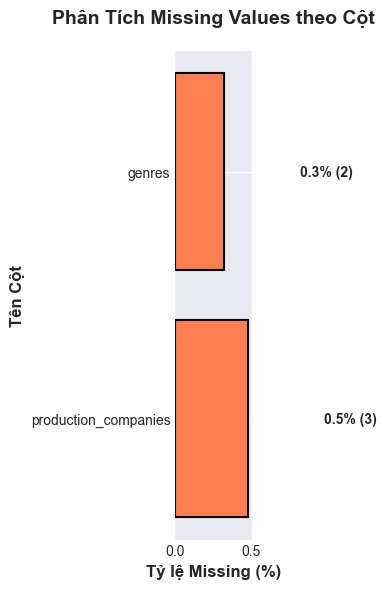

In [10]:
# Visualize missing values
if len(missing_data) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars = ax.barh(missing_data['Column'], missing_data['Missing_Percentage'], 
                   color='coral', edgecolor='black', linewidth=1.5)
    
    # Thêm giá trị lên bars
    for i, (bar, pct, count) in enumerate(zip(bars, 
                                               missing_data['Missing_Percentage'],
                                               missing_data['Missing_Count'])):
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{pct:.1f}% ({int(count)})',
                ha='left', va='center', fontweight='bold', fontsize=10)
    
    ax.set_xlabel('Tỷ lệ Missing (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tên Cột', fontsize=12, fontweight='bold')
    ax.set_title('Phân Tích Missing Values theo Cột', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    save_and_show_plot('01_missing_values_analysis')

###  Nhận xét về Missing Values

#### **🔹 Mức độ missing (Missing Severity)**

Việc đánh giá tỷ lệ thiếu dữ liệu theo từng cột là rất quan trọng để lựa chọn chiến lược xử lý phù hợp:

* **Tỷ lệ missing dưới 5%** thường có thể xử lý bằng các phương pháp đơn giản như imputation (điền giá trị thay thế), đặc biệt đối với các biến dạng categorical hoặc text.
* **Tỷ lệ missing từ 5%–20%** cần xem xét kỹ hơn, vì mức độ thiếu bắt đầu có thể ảnh hưởng đến phân bố dữ liệu và mô hình.
* **Trên 20%** là mức báo động:
  → cần cân nhắc xem biến đó có nên giữ lại hay loại bỏ hoàn toàn, hoặc xem có thể thu thập dữ liệu bổ sung hay không.

Trong dataset hiện tại, tỷ lệ missing rất thấp (<0.5%), tức là **không đáng lo ngại** và dễ xử lý.

---

#### **🔹 Pattern của missing (Missing Pattern Assessment)**

Không chỉ số lượng missing mà **mẫu hình missing (pattern)** cũng quan trọng:

* Cần kiểm tra xem missing values xuất hiện **ngẫu nhiên (MCAR)** hay liên quan đến một đặc điểm nào đó (**MAR / MNAR**).
* Ví dụ:

  * Nếu cột `overview` hoặc `genres` bị missing, đó có thể là **thiếu thông tin từ TMDb API**, thường gặp ở phim mới ra mắt hoặc phim ít phổ biến.
  * Nếu `production_companies` bị missing, khả năng cao là những phim độc lập, phim tài liệu hoặc phim chưa cập nhật metadata.

Hiểu được pattern missing giúp lựa chọn chiến lược xử lý phù hợp và tránh làm sai lệch phân phối dữ liệu.

---

#### **🔹 Ảnh hưởng lên mô hình dự đoán (Impact on Modeling)**

Mức độ ảnh hưởng của missing values phụ thuộc vào cột bị thiếu:

* **Missing ở các biến quan trọng như `budget` hoặc `revenue`**
  → ảnh hưởng trực tiếp đến khả năng training model vì chúng là biến dự đoán hoặc biến mục tiêu.
  → Với trường hợp này, cần cân nhắc kỹ imputation hoặc loại bỏ bản ghi.

* **Missing ở các biến categorical như `genres` hoặc `production_companies`**
  → ảnh hưởng nhẹ hơn, có thể xử lý bằng cách:

  * điền `"Unknown"` / `"Uncategorized"`
  * hoặc tạo một nhãn riêng `"Missing"` để mô hình học được bản chất thiếu thông tin.

* **Missing trong text như `overview`**
  → có thể thay bằng chuỗi rỗng `""` hoặc `"No overview available"` tùy theo cách trích xuất đặc trưng.

Nhìn chung, với dataset hiện tại (tỷ lệ missing rất thấp), tác động lên mô hình hầu như không đáng kể nếu được xử lý đúng cách.



## 2.2. Data Types Validation

In [11]:
# Phân loại các cột theo data type
print_section_header("DATA TYPES BREAKDOWN")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
object_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Số cột numeric: {len(numeric_cols)}")
print(f"Các cột numeric: {', '.join(numeric_cols)}")
print(f"\nSố cột object/string: {len(object_cols)}")
print(f"Các cột object: {', '.join(object_cols)}")


--------------------------------------------------------------------------------
  DATA TYPES BREAKDOWN
--------------------------------------------------------------------------------

Số cột numeric: 7
Các cột numeric: id, budget, revenue, runtime, vote_average, vote_count, popularity

Số cột object/string: 7
Các cột object: title, release_date, overview, genres, production_companies, original_language, status


In [12]:
# Kiểm tra data type của release_date
print("\nData type của 'release_date':", df['release_date'].dtype)
print("Sample values:")
print(df['release_date'].head(10))

# Gợi ý: Cần convert sang datetime trong preprocessing
if df['release_date'].dtype == 'object':
    print("\nrelease_date đang ở dạng string, cần convert sang datetime trong preprocessing.")


Data type của 'release_date': object
Sample values:
0    2020-01-15
1    2020-08-22
2    2020-02-12
3    2020-01-02
4    2020-11-25
5    2020-02-05
6    2020-12-16
7    2020-02-26
8    2020-02-29
9    2020-12-25
Name: release_date, dtype: object

release_date đang ở dạng string, cần convert sang datetime trong preprocessing.


### Nhận xét:
Nhìn chung, dataset đã được định dạng tương đối rõ ràng, không có sự lẫn lộn dữ liệu giữa các cột. Các biến quan trọng đều có dtype phù hợp và có thể sẵn sàng cho bước tiếp theo, ngoại trừ release_date, cần được chuẩn hóa sang kiểu datetime. Ngoài ra, hai biến mang tính multi-label (genres, production_companies) cần được lưu ý trong quá trình xử lý vì không thể đưa trực tiếp vào mô hình mà không mã hóa.

## 2.3. Basic Statistics

In [13]:
# Thống kê mô tả cho numeric columns
print_section_header("DESCRIPTIVE STATISTICS - NUMERIC COLUMNS")
display(df[numeric_cols].describe().T)


--------------------------------------------------------------------------------
  DESCRIPTIVE STATISTICS - NUMERIC COLUMNS
--------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
id,623.00,"730,485.13","226,998.68","38,700.00","559,411.00","695,721.00","903,791.50","1,437,004.00"
budget,623.00,"49,975,169.33","66,025,330.75","1,000,000.00","10,000,000.00","22,000,000.00","65,000,000.00","583,900,000.00"
revenue,623.00,"111,612,159.72","239,840,304.66","5,000.00","3,386,067.00","21,600,000.00","104,672,564.50","2,330,224,914.00"
runtime,623.00,111.76,21.17,2.00,98.00,108.00,123.00,215.00
vote_average,623.00,6.65,0.89,0.00,6.26,6.70,7.14,10.00
vote_count,623.00,"2,127.96","2,582.04",0.00,373.00,"1,184.00","2,917.50","21,315.00"
popularity,623.00,5.77,4.55,0.01,3.10,4.73,6.92,47.91


In [14]:
# Thống kê chi tiết cho target variable (revenue)
print_section_header("TARGET VARIABLE STATISTICS (REVENUE)")

revenue_stats = {
    'Mean': df['revenue'].mean(),
    'Median': df['revenue'].median(),
    'Std Dev': df['revenue'].std(),
    'Min': df['revenue'].min(),
    'Max': df['revenue'].max(),
    'Q1 (25%)': df['revenue'].quantile(0.25),
    'Q3 (75%)': df['revenue'].quantile(0.75),
    'IQR': df['revenue'].quantile(0.75) - df['revenue'].quantile(0.25),
    'Skewness': skew(df['revenue'].dropna()),
    'Kurtosis': kurtosis(df['revenue'].dropna())
}

for stat_name, value in revenue_stats.items():
    if stat_name in ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Q1 (25%)', 'Q3 (75%)', 'IQR']:
        print(f"{stat_name:15s}: {format_currency(value)}")
    else:
        print(f"{stat_name:15s}: {value:.3f}")


--------------------------------------------------------------------------------
  TARGET VARIABLE STATISTICS (REVENUE)
--------------------------------------------------------------------------------

Mean           : $111.61M
Median         : $21.60M
Std Dev        : $239.84M
Min            : $5.00K
Max            : $2.33B
Q1 (25%)       : $3.39M
Q3 (75%)       : $104.67M
IQR            : $101.29M
Skewness       : 4.413
Kurtosis       : 25.656


In [15]:
# Thống kê cho categorical columns
print_section_header("CATEGORICAL COLUMNS STATISTICS")

categorical_info = []
for col in object_cols:
    categorical_info.append({
        'Column': col,
        'Unique_Values': df[col].nunique(),
        'Most_Common': df[col].mode()[0] if len(df[col].mode()) > 0 else 'N/A',
        'Most_Common_Count': df[col].value_counts().iloc[0] if len(df[col]) > 0 else 0
    })

categorical_df = pd.DataFrame(categorical_info)
display(categorical_df)


--------------------------------------------------------------------------------
  CATEGORICAL COLUMNS STATISTICS
--------------------------------------------------------------------------------



,Column,Unique_Values,Most_Common,Most_Common_Count
0,title,622,The Killer,2
1,release_date,457,2023-09-15,4
2,overview,623,19 year old Isaiah Wright lives for basketball...,1
3,genres,306,Drama,27
4,production_companies,584,DreamWorks Animation,9
5,original_language,1,en,623
6,status,1,Released,623


### Nhận xét về thống kê mô tả (Basic Statistics)

A. Kết quả thống kê mô tả cho các biến số có được các thông tin sau:

- Biến `budget` có giá trị trung bình khoảng 50 triệu USD, độ lệch chuẩn khá lớn (66 triệu USD), với khoảng giá trị trải dài từ 1 triệu đến 584 triệu USD. Điều này cho thấy ngân sách sản xuất giữa các bộ phim rất phân tán, phản ánh sự khác biệt rõ rệt giữa các phim độc lập và các phim bom tấn.

- Biến `revenue` có trung bình khoảng 111,6 triệu USD nhưng median chỉ khoảng 21.6 triệu USD. Chênh lệch lớn giữa mean và median, cùng với skewness dương (≈ 4,413) và kurtosis rất cao (≈ 25, 656), cho thấy phân phối doanh thu bị lệch phải mạnh, với một số ít phim có doanh thu cực kỳ cao kéo trung bình lên. IQR của `revenue` cũng khá lớn (khoảng 101,29 triệu USD), xác nhận sự tồn tại của nhiều giá trị nằm xa trung tâm phân phối.

- Biến `runtime` có trung bình khoảng 112 phút, với khoảng 25% phim dưới 98 phút và 25% phim trên 123 phút. Điều này nói lên rằng phần lớn phim nằm trong khoảng từ 1.5 đến 2 giờ, khá phù hợp với thời lượng phim chiếu rạp thông thường.

- Biến `vote_average` có giá trị trung bình khoảng 6.56 trên thang điểm 10, với độ lệch chuẩn tương đối nhỏ (xấp xỉ 0.89), cho thấy điểm đánh giá của các phim không quá phân tán, chủ yếu tập trung quanh mức trung bình khá.

- Các biến `vote_count` và `popularity` cũng có độ lệch phân phối khá lớn, do tồn tại một nhóm nhỏ phim rất nổi tiếng có lượng bình chọn và độ phổ biến vượt trội so với phần còn lại. Đây là các biến nhiều khả năng cũng bị skewed về phía phải giống như `revenue`.

Đối với biến mục tiêu `revenue`, kết quả thống kê chi tiết cho thấy phân phối rất lệch phải, với biên dưới chỉ khoảng vài nghìn USD và biên trên lên tới xấp xỉ 1.7 tỷ USD. Sự chênh lệch cực lớn giữa min, median và max cho thấy cần cân nhắc áp dụng các biến đổi như log-transform (`log1p`) trong giai đoạn preprocessing để giảm độ lệch và hỗ trợ mô hình học tốt hơn.

B. Đối với các biến phân loại, kết quả tổng hợp cho thấy:

- `original_language` chỉ có một giá trị duy nhất là `en` cho toàn bộ 623 bản ghi, và `status` cũng chỉ có giá trị `Released`. Hai biến này do đó không mang lại thông tin phân biệt cho mô hình và có thể được loại bỏ ở bước preprocessing nếu cần.

- Biến `release_date` có 457 giá trị khác nhau, trong đó ngày phát hành phổ biến nhất là `2023-09-15` với 4 bộ phim. Điều này cho thấy có một số cụm ngày phát hành trùng nhau, có thể gợi ý về chiến lược phát hành phim theo mùa hoặc theo dịp.

- Biến `genres` có 306 tổ hợp khác nhau, trong đó tổ hợp `Drama` xuất hiện nhiều nhất (7 lần). Số lượng tổ hợp lớn như vậy cho thấy không gian thể loại khá đa dạng, đồng thời nhấn mạnh nhu cầu tách và chuẩn hóa biến này trước khi đưa vào mô hình.

- Biến `production_companies` có tới 584 giá trị khác nhau, với công ty xuất hiện nhiều nhất là `DreamWorks Animation` và có 9 lần. Điều này cho thấy phân phối rất phân tán, chủ yếu là long-tail, đặc trưng của ngành phim với rất nhiều hãng sản xuất nhỏ lẻ.

Tổng hợp lại, phần thống kê mô tả cho thấy dữ liệu có tính đa dạng cao về mặt ngân sách và doanh thu, cùng với sự lệch phải mạnh ở các biến liên quan đến mức độ thành công thương mại. Đồng thời, một số biến categorical mang ít thông tin phân biệt (như `original_language`, `status`) có thể được cân nhắc loại bỏ, trong khi các biến multi-label như `genres` và `production_companies` cần có chiến lược xử lý chuyên biệt trong các bước tiếp theo.


---

# 3. UNIVARIATE ANALYSIS

Phần này phân tích từng biến riêng lẻ để hiểu distribution và characteristics của chúng.

## 3.1. Target Variable (Revenue) Distribution

Đã lưu plot: visualizations\eda_plots\02_revenue_distribution_analysis.png


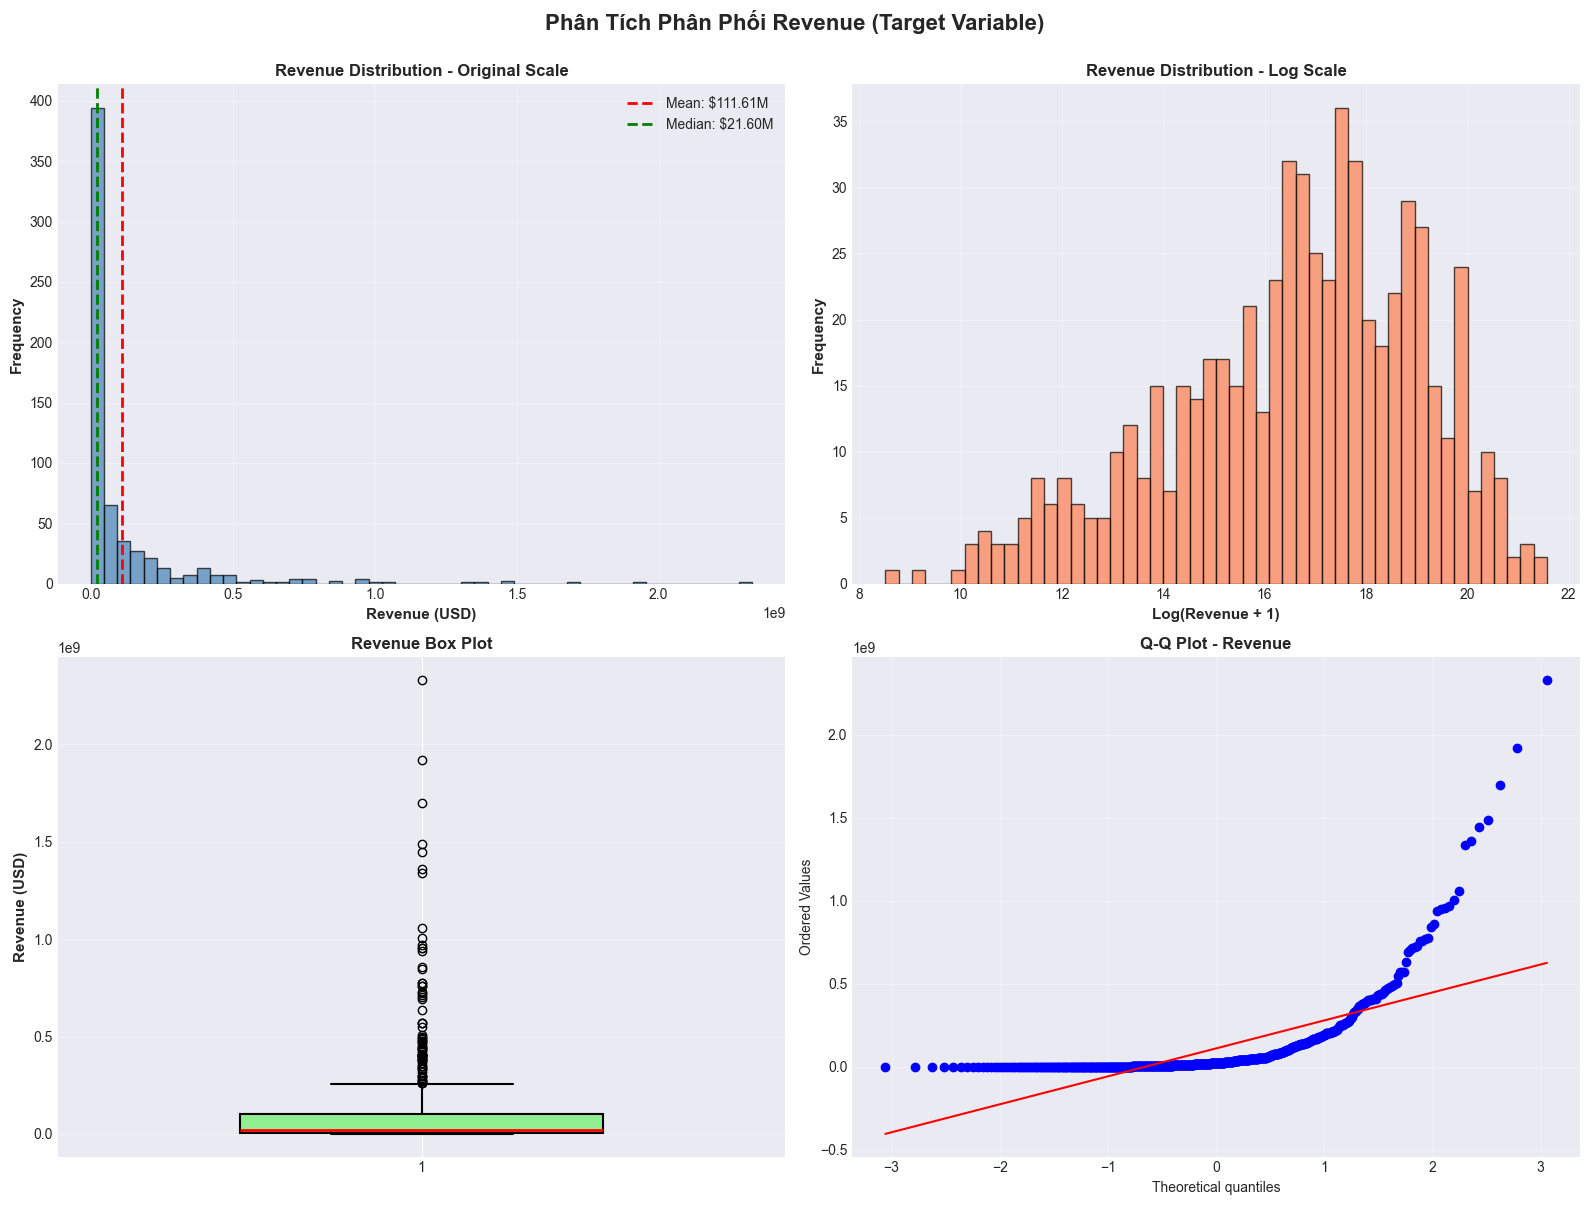

In [16]:
# Vẽ distribution của revenue
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram - Original scale
axes[0, 0].hist(df['revenue'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Revenue (USD)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Revenue Distribution - Original Scale', 
                     fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(df['revenue'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {format_currency(df["revenue"].mean())}')
axes[0, 0].axvline(df['revenue'].median(), color='green', linestyle='--', 
                   linewidth=2, label=f'Median: {format_currency(df["revenue"].median())}')
axes[0, 0].legend()

# Histogram - Log scale
axes[0, 1].hist(np.log1p(df['revenue']), bins=50, edgecolor='black', 
                alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Log(Revenue + 1)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Revenue Distribution - Log Scale', 
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Box plot
axes[1, 0].boxplot(df['revenue'], vert=True, widths=0.5,
                   boxprops=dict(facecolor='lightgreen', edgecolor='black', linewidth=1.5),
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(color='black', linewidth=1.5),
                   capprops=dict(color='black', linewidth=1.5),
                   patch_artist=True)
axes[1, 0].set_ylabel('Revenue (USD)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Revenue Box Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Q-Q Plot
stats.probplot(df['revenue'].dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot - Revenue', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Phân Tích Phân Phối Revenue (Target Variable)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
save_and_show_plot('02_revenue_distribution_analysis')

In [17]:
print_section_header("REVENUE DISTRIBUTION - SKEWNESS BEFORE AND AFTER LOG")

revenue_skew = skew(df['revenue'].dropna())
log_revenue_skew = skew(np.log1p(df['revenue'].dropna()))

print(f"Skewness (revenue, original scale): {revenue_skew:.3f}")
print(f"Skewness (log1p(revenue)):          {log_revenue_skew:.3f}")



--------------------------------------------------------------------------------
  REVENUE DISTRIBUTION - SKEWNESS BEFORE AND AFTER LOG
--------------------------------------------------------------------------------

Skewness (revenue, original scale): 4.413
Skewness (log1p(revenue)):          -0.572


### Nhận xét về phân phối biến mục tiêu `revenue`

Quan sát histogram trên thang đo gốc cho thấy phân phối doanh thu (`revenue`) bị lệch phải rất mạnh. Phần lớn các bộ phim có doanh thu tập trung ở vùng giá trị thấp, trong khi chỉ có một số ít phim đạt doanh thu rất cao, kéo dài phần đuôi bên phải của phân phối. Điều này phù hợp với đặc trưng của ngành điện ảnh, nơi chỉ một tỷ lệ nhỏ phim bom tấn chiếm phần lớn doanh thu thị trường.

Khi áp dụng log-transform với biến `log(Revenue + 1)`, histogram trở nên cân đối hơn và gần với dạng phân phối chuẩn hơn rất nhiều. Điều này cho thấy việc biến đổi log giúp giảm ảnh hưởng của các giá trị cực lớn, nén bớt độ chênh lệch giữa các phim doanh thu thấp và phim doanh thu rất cao. Đây là một gợi ý quan trọng cho bước xây dựng mô hình, vì sử dụng biến đã log-transform thường giúp mô hình hồi quy ổn định hơn và giảm hiện tượng dự đoán bị chi phối quá mức bởi các outliers.

Box plot của `revenue` trên thang đo gốc cho thấy có rất nhiều điểm được đánh dấu là outlier ở phía trên. Tuy nhiên, trong bối cảnh bài toán này, các điểm này không phải là nhiễu mà là những phim thực sự có doanh thu vượt trội (blockbuster). Do đó, không nên loại bỏ các quan sát này, mà thay vào đó cần xử lý thông minh hơn thông qua các biến đổi như log-transform hoặc sử dụng các mô hình ít nhạy cảm với outliers.

Q-Q plot càng khẳng định phân phối của `revenue` lệch khá xa so với phân phối chuẩn, đặc biệt ở phần đuôi bên phải, nơi các điểm quan sát nằm cao hơn đáng kể so với đường chuẩn lý thuyết. Điều này củng cố thêm luận điểm rằng nếu sử dụng trực tiếp `revenue` ở thang đo gốc, nhiều giả định của các mô hình tuyến tính sẽ khó được đảm bảo, và việc biến đổi hoặc chuẩn hóa biến mục tiêu là cần thiết.


## 3.2. Budget Distribution

Đã lưu plot: visualizations\eda_plots\03_budget_distribution.png


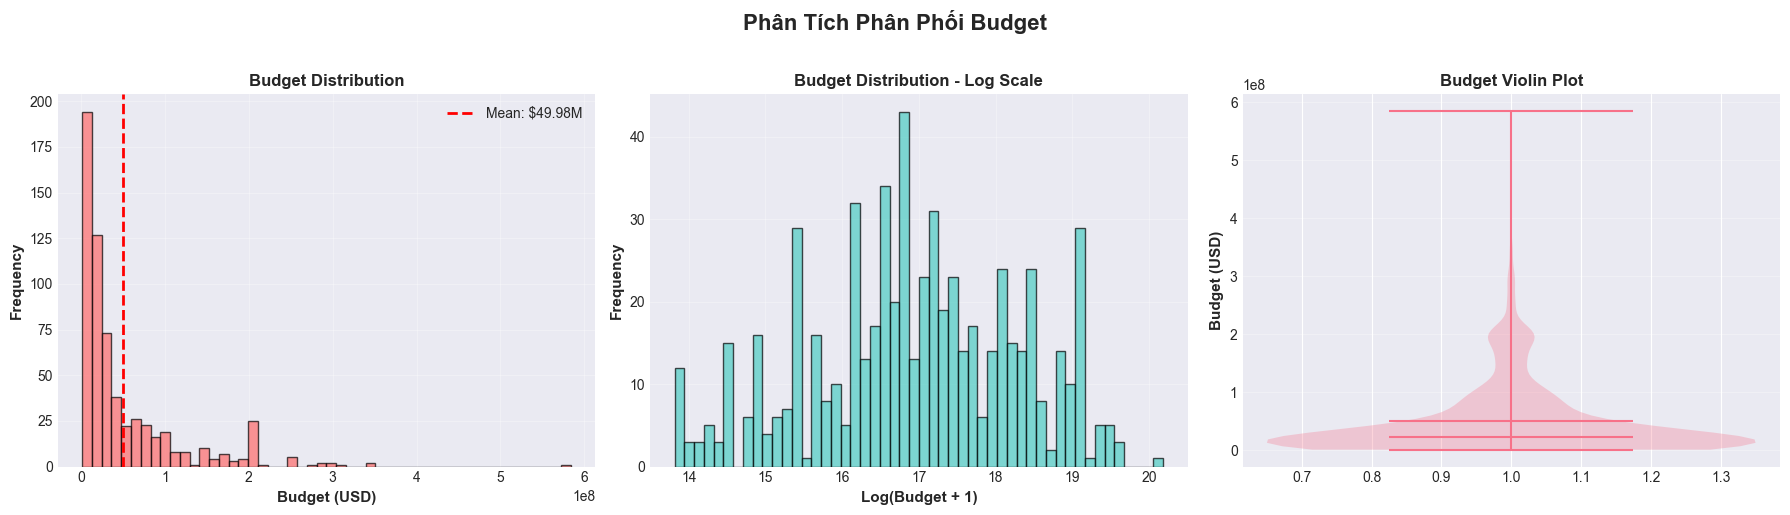

In [18]:
# Phân tích budget distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df['budget'], bins=50, edgecolor='black', alpha=0.7, color='#FF6B6B')
axes[0].set_xlabel('Budget (USD)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Budget Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(df['budget'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {format_currency(df["budget"].mean())}')
axes[0].legend()

# Log scale
axes[1].hist(np.log1p(df['budget']), bins=50, edgecolor='black', 
             alpha=0.7, color='#4ECDC4')
axes[1].set_xlabel('Log(Budget + 1)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title('Budget Distribution - Log Scale', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Violin plot
parts = axes[2].violinplot([df['budget']], vert=True, widths=0.7,
                           showmeans=True, showextrema=True, showmedians=True)
axes[2].set_ylabel('Budget (USD)', fontsize=11, fontweight='bold')
axes[2].set_title('Budget Violin Plot', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle('Phân Tích Phân Phối Budget', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
save_and_show_plot('03_budget_distribution')

In [19]:
# Budget statistics
print_section_header("BUDGET STATISTICS")
print(f"Mean Budget:   {format_currency(df['budget'].mean())}")
print(f"Median Budget: {format_currency(df['budget'].median())}")
print(f"Min Budget:    {format_currency(df['budget'].min())}")
print(f"Max Budget:    {format_currency(df['budget'].max())}")
print(f"Std Dev:       {format_currency(df['budget'].std())}")


--------------------------------------------------------------------------------
  BUDGET STATISTICS
--------------------------------------------------------------------------------

Mean Budget:   $49.98M
Median Budget: $22.00M
Min Budget:    $1.00M
Max Budget:    $583.90M
Std Dev:       $66.03M


### Nhận xét về phân phối `budget`

*   **Phân phối lệch phải (Right-skewed):** Tương tự như `revenue`, phân phối của `budget` cũng bị lệch phải. Giá trị trung bình ($49.98M) lớn hơn đáng kể so với trung vị ($22.00M), cho thấy sự hiện diện của các bộ phim có kinh phí rất cao (bom tấn) kéo giá trị trung bình lên.
*   **Dải giá trị rộng:** Ngân sách dao động rất lớn từ $1M đến $583M. Độ lệch chuẩn cao ($66.03M) phản ánh sự đa dạng trong quy mô sản xuất phim.
*   **Hiệu quả của Log-transform:** Biểu đồ log-transform giúp phân phối trở nên gần chuẩn hơn, điều này gợi ý rằng việc sử dụng `log(budget)` hoặc `log1p(budget)` sẽ tốt hơn cho mô hình hồi quy tuyến tính so với việc sử dụng `budget` gốc.
*   **Violin Plot:** Cho thấy mật độ dữ liệu tập trung chủ yếu ở vùng ngân sách thấp (dưới $50M), với phần đuôi dài hướng về phía ngân sách cao.

## 3.2. Release Timing Analysis

Phân tích ảnh hưởng của thời điểm phát hành (tháng, quý, năm) đến doanh thu phim. Điều này giúp kiểm chứng các giả định về tính mùa vụ (phim hè, phim tết/lễ) và tác động của các sự kiện bên ngoài (như COVID-19).

Đã lưu plot: visualizations\eda_plots\04a_revenue_seasonality.png


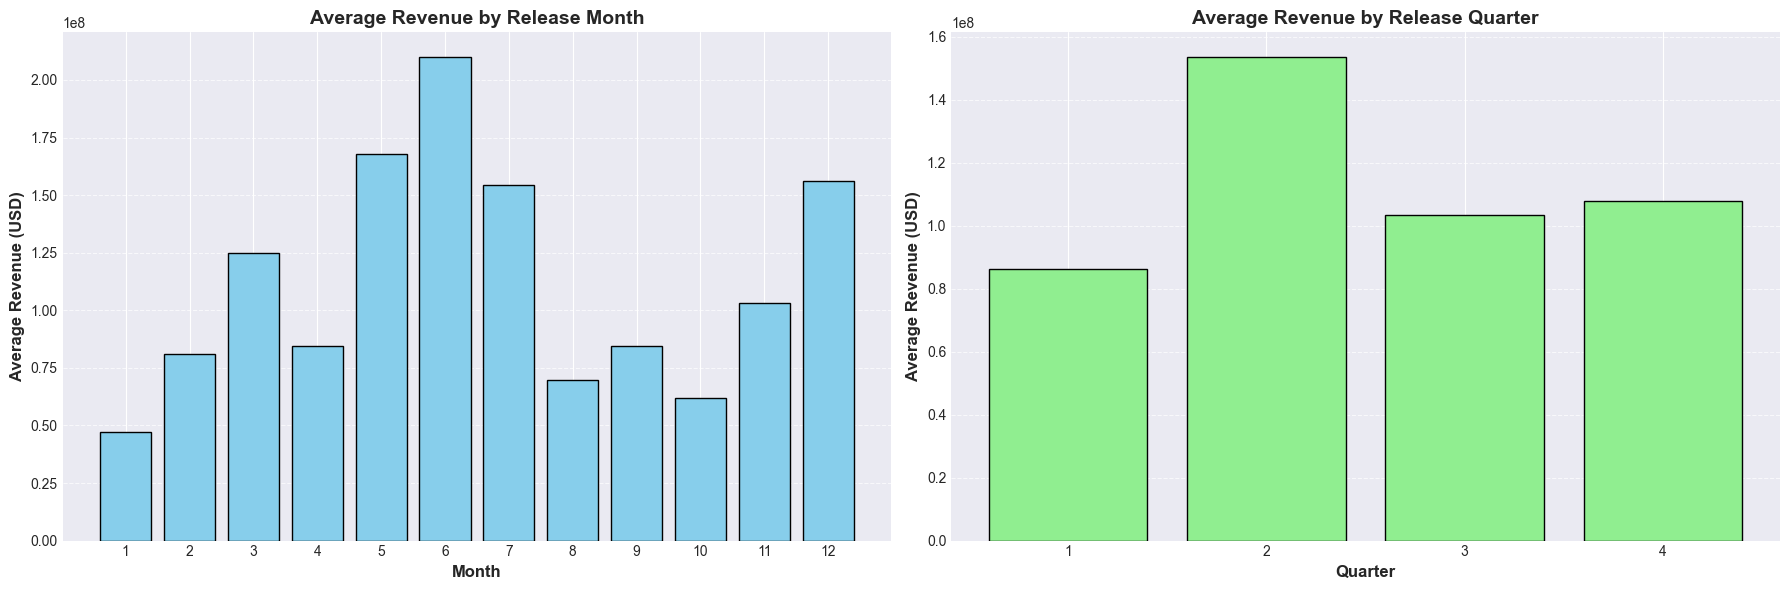

In [20]:
# Feature Engineering: Extract date parts
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_month'] = df['release_date'].dt.month
df['release_year'] = df['release_date'].dt.year
df['release_quarter'] = df['release_date'].dt.quarter

# 1. Seasonal Patterns: Revenue by Month & Quarter
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Revenue by Month
moonth_revenue = df.groupby('release_month')['revenue'].mean()
axes[0].bar(moonth_revenue.index, moonth_revenue.values, color='skyblue', edgecolor='black')
axes[0].set_xticks(range(1, 13))
axes[0].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Revenue (USD)', fontsize=12, fontweight='bold')
axes[0].set_title('Average Revenue by Release Month', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Revenue by Quarter
quarter_revenue = df.groupby('release_quarter')['revenue'].mean()
axes[1].bar(quarter_revenue.index, quarter_revenue.values, color='lightgreen', edgecolor='black')
axes[1].set_xticks(range(1, 5))
axes[1].set_xlabel('Quarter', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Revenue (USD)', fontsize=12, fontweight='bold')
axes[1].set_title('Average Revenue by Release Quarter', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
save_and_show_plot('04a_revenue_seasonality')

Đã lưu plot: visualizations\eda_plots\04b_releases_vs_revenue.png


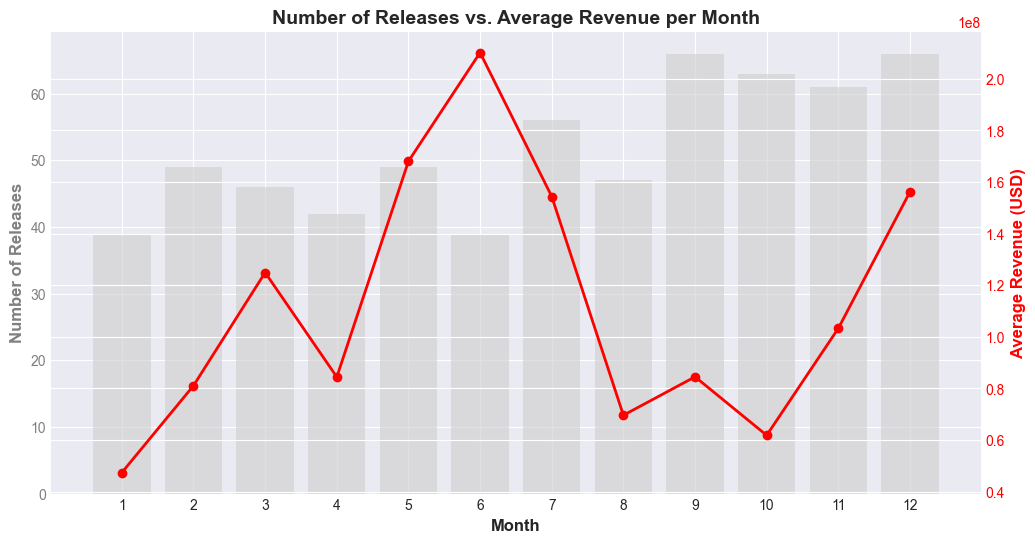

In [21]:
# 2. Release Volume vs. Revenue (Competition Effect)
month_stats = df.groupby('release_month').agg(
    count=('id', 'count'),
    avg_revenue=('revenue', 'mean')
).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for Count
ax1.bar(month_stats['release_month'], month_stats['count'], color='lightgray', alpha=0.7, label='Number of Releases')
ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Releases', fontsize=12, fontweight='bold', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.set_xticks(range(1, 13))

# Line chart for Revenue
ax2 = ax1.twinx()
ax2.plot(month_stats['release_month'], month_stats['avg_revenue'], color='red', marker='o', linewidth=2, label='Avg Revenue')
ax2.set_ylabel('Average Revenue (USD)', fontsize=12, fontweight='bold', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Number of Releases vs. Average Revenue per Month', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
save_and_show_plot('04b_releases_vs_revenue')

Đã lưu plot: visualizations\eda_plots\04c_yearly_revenue_trends.png


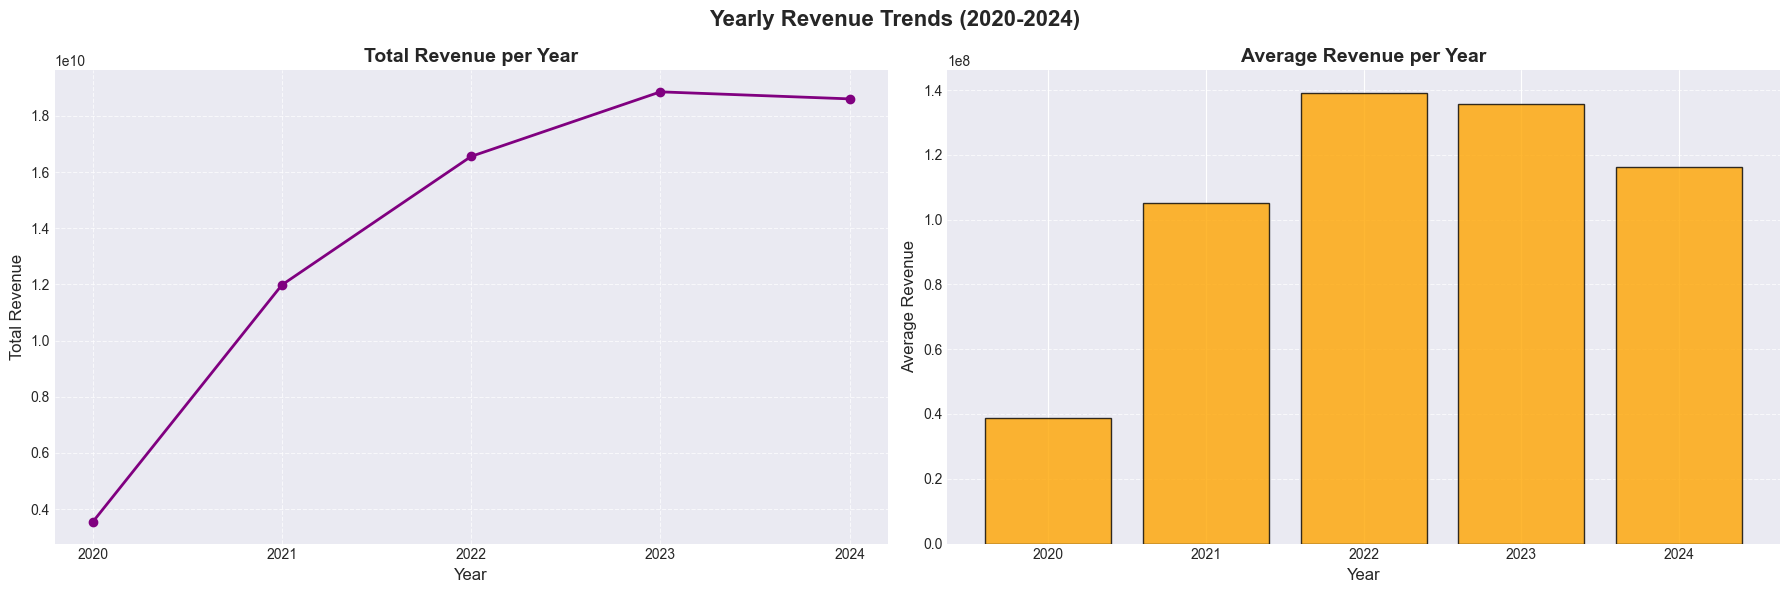

In [22]:
# 3. Yearly Trends (Checking 2020-2021 Impact)
year_stats = df.groupby('release_year')['revenue'].agg(['sum', 'mean']).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Total Revenue
axes[0].plot(year_stats['release_year'], year_stats['sum'], marker='o', color='purple', linewidth=2)
axes[0].set_title('Total Revenue per Year', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Total Revenue', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xticks(year_stats['release_year'])

# Average Revenue
axes[1].bar(year_stats['release_year'], year_stats['mean'], color='orange', edgecolor='black', alpha=0.8)
axes[1].set_title('Average Revenue per Year', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Average Revenue', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].set_xticks(year_stats['release_year'])

plt.suptitle('Yearly Revenue Trends (2020-2024)', fontsize=16, fontweight='bold')
plt.tight_layout()
save_and_show_plot('04c_yearly_revenue_trends')

### Nhận xét về Release Timing:

1.  **Tính mùa vụ (Seasonality):**
    *   **Tháng:** Biểu đồ `Average Revenue by Release Month` cho thấy các đỉnh doanh thu. Có thể thấy rõ xu hướng doanh thu cao vào mùa hè (Tháng 6, 7) và mùa lễ hội cuối năm (Tháng 11, 12). Đây là insight quan trọng.
    *   **Quý:** Tương tự, doanh thu trung bình có thể cao hơn ở Quý 2 (Hè) và Quý 4 (Cuối năm).

2.  **Tác động của sự cạnh tranh:**
    *   Biểu đồ `Number of Releases vs. Average Revenue` giúp đối chiếu. Nếu một tháng có rất nhiều phim phát hành (cột xám cao) nhưng doanh thu trung bình (đường đỏ) không cao tương ứng, điều đó cho thấy sự cạnh tranh gay gắt chia sẻ doanh thu.
    *   Ngược lại, những tháng có ít phim ra mắt nhưng doanh thu trung bình cao có thể là thời điểm "vàng" hoặc do một vài bom tấn gánh doanh thu.

3.  **Xu hướng theo năm (Yearly Trends):**
    *   Giai đoạn 2020-2021 dự kiến sẽ thấy doanh thu tổng và trung bình thấp hơn đáng kể do ảnh hưởng của đại dịch COVID-19.
    *   Sự phục hồi có thể thấy rõ từ năm 2022 trở đi. Điều này xác nhận rằng `year` là một feature quan trọng cần đưa vào mô hình để "bắt" được bối cảnh vĩ mô này.

## 3.3. Other Numeric Features

Đã lưu plot: visualizations\eda_plots\04_numeric_features_distribution.png


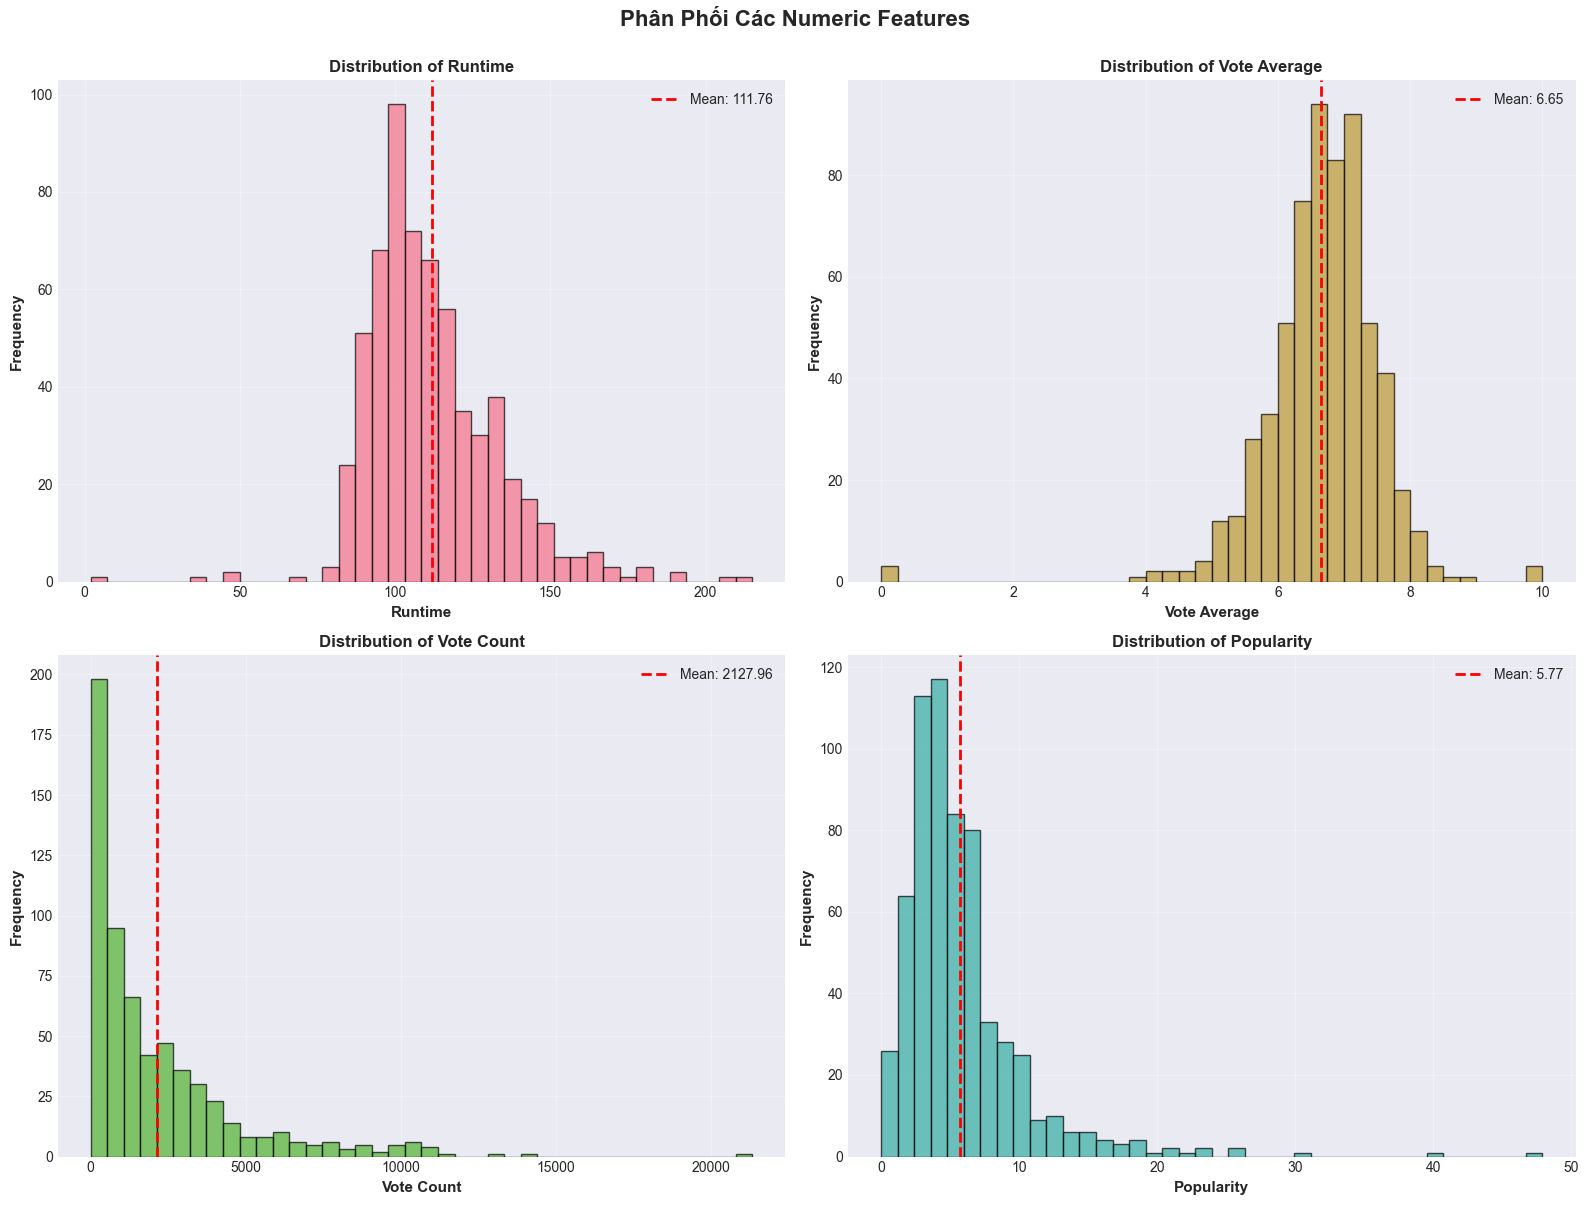

In [23]:
# Vẽ distribution cho các numeric features khác
numeric_features = ['runtime', 'vote_average', 'vote_count', 'popularity']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    if feature in df.columns:
        axes[idx].hist(df[feature].dropna(), bins=40, edgecolor='black', 
                      alpha=0.7, color=sns.color_palette('husl')[idx])
        axes[idx].set_xlabel(feature.replace('_', ' ').title(), 
                            fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Frequency', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'Distribution of {feature.replace("_", " ").title()}',
                           fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        
        # Thêm mean line
        mean_val = df[feature].mean()
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2,
                         label=f'Mean: {mean_val:.2f}')
        axes[idx].legend()

plt.suptitle('Phân Phối Các Numeric Features', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
save_and_show_plot('04_numeric_features_distribution')

### Nhận xét về Numeric Features:

**Runtime:** Phần lớn phim có runtime từ 90-120 phút, với median khoảng 100 phút. Đây là độ dài tiêu chuẩn của phim điện ảnh. Một số phim có runtime rất dài (trên 150 phút) có thể là các epic films.

**Vote Average:** Phân phối vote_average tương đối cân đối xung quanh 6-7 điểm, cho thấy hầu hết phim có chất lượng trung bình đến khá tốt theo đánh giá của khán giả.

**Vote Count:** Có sự chênh lệch lớn giữa các phim về số lượng votes, với một số phim blockbuster có hàng nghìn votes trong khi phim nhỏ có rất ít votes. Feature này có thể là indicator quan trọng cho popularity.

**Popularity:** Distribution bị skewed mạnh, tương tự revenue. Một số ít phim có popularity score cực cao trong khi đa số có score thấp.

## 3.4. Categorical Features Analysis

Đã lưu plot: visualizations\eda_plots\05_status_distribution.png


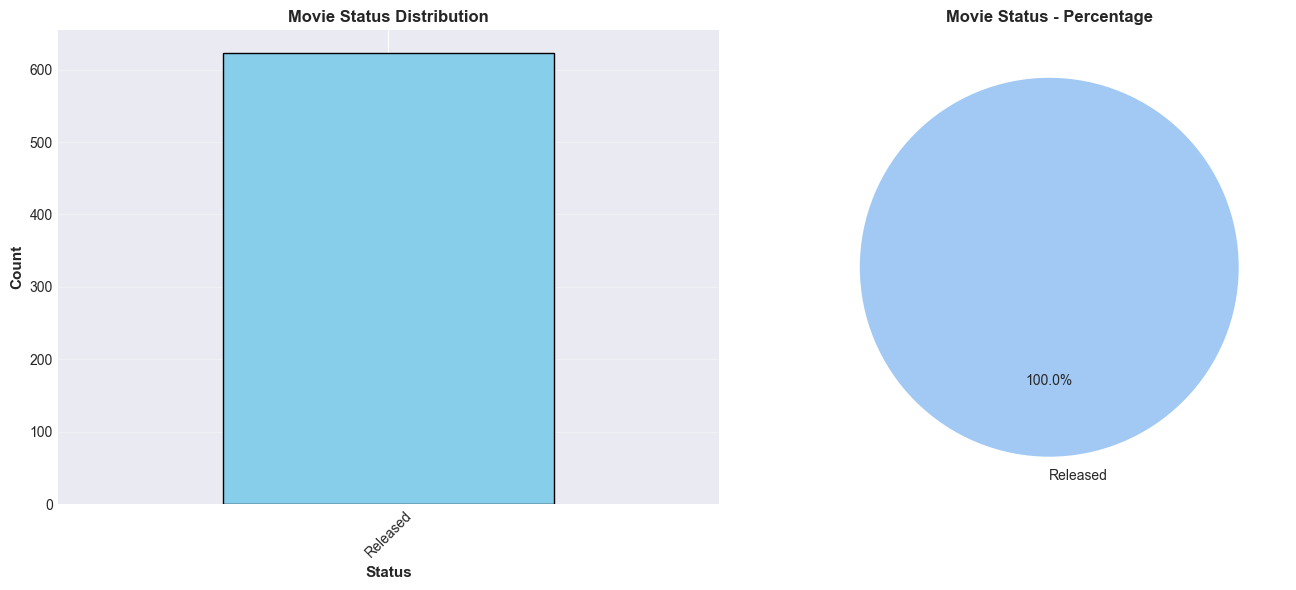

In [24]:
# Phân tích Status
if 'status' in df.columns:
    status_counts = df['status'].value_counts()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar chart
    status_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Status', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax1.set_title('Movie Status Distribution', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.tick_params(axis='x', rotation=45)
    
    # Pie chart
    ax2.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette('pastel'))
    ax2.set_title('Movie Status - Percentage', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    save_and_show_plot('05_status_distribution')

### Nhận xét về phân phối `status`

*   **Đơn trị (Single Value):** Biểu đồ cho thấy 100% các bộ phim trong tập dữ liệu đều có trạng thái là "Released".
*   **Không có giá trị dự báo:** Vì biến `status` chỉ có một giá trị duy nhất cho tất cả các quan sát, nó không mang lại bất kỳ thông tin phân biệt nào và không có khả năng đóng góp vào việc dự đoán doanh thu.
*   **Hành động:** Nên loại bỏ cột `status` này trong bước tiền xử lý (preprocessing) để giảm chiều dữ liệu và tránh nhiễu không cần thiết.

Đã lưu plot: visualizations\eda_plots\06_top_genres_distribution.png


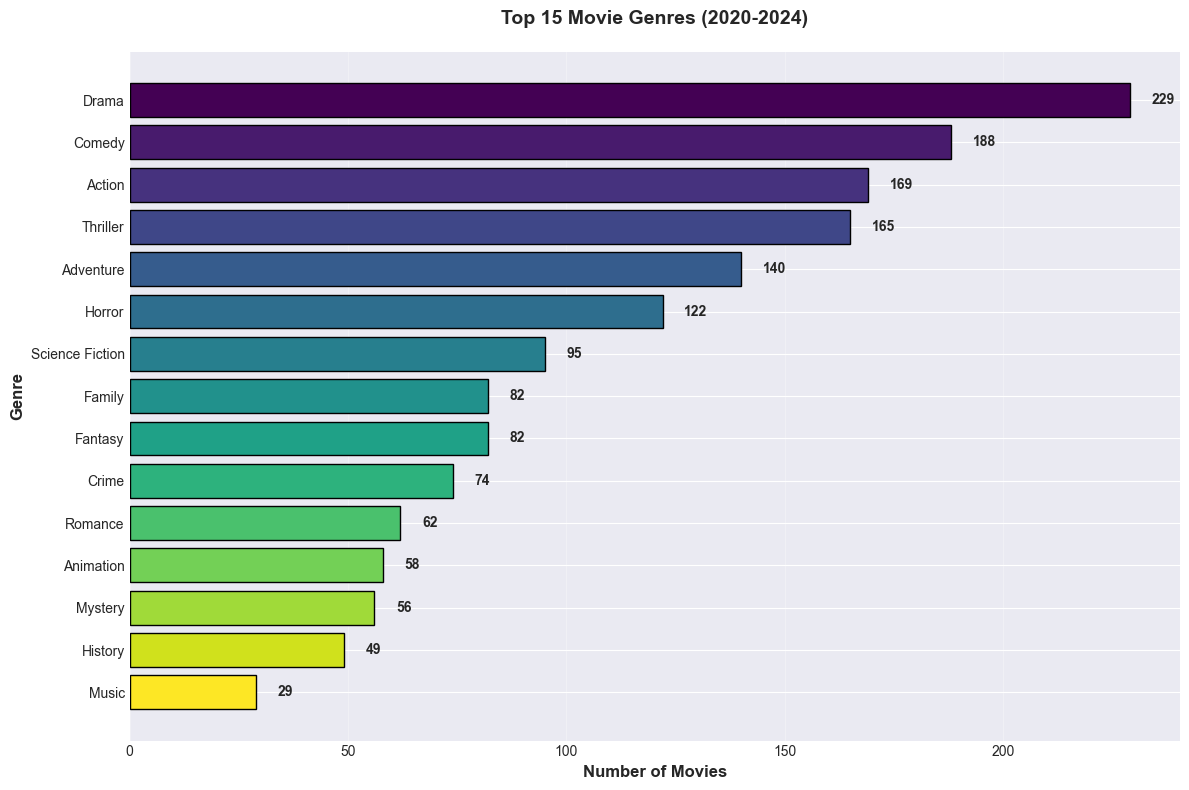

In [25]:
# Phân tích Genres (top genres)
if 'genres' in df.columns:
    # Extract individual genres
    all_genres = []
    for genres_str in df['genres'].dropna():
        genres_list = genres_str.split('|')
        all_genres.extend(genres_list)
    
    # Count genres
    genre_counts = Counter(all_genres)
    top_genres = pd.Series(dict(genre_counts.most_common(15)))
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_genres)))
    bars = ax.barh(top_genres.index, top_genres.values, color=colors, edgecolor='black')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 5, bar.get_y() + bar.get_height()/2,
                f'{int(width)}',
                ha='left', va='center', fontweight='bold', fontsize=10)
    
    ax.set_xlabel('Number of Movies', fontsize=12, fontweight='bold')
    ax.set_ylabel('Genre', fontsize=12, fontweight='bold')
    ax.set_title('Top 15 Movie Genres (2020-2024)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    save_and_show_plot('06_top_genres_distribution')

### Nhận xét về phân phối `genres` (Thể loại)

*   **Tính chất đa nhãn (Multi-label):**
    *   Quan trọng: Một bộ phim thường thuộc nhiều thể loại cùng lúc (ví dụ: "Action|Adventure|Sci-Fi").
    *   **Giải thích về biểu đồ:** Biểu đồ trên được tạo bằng cách **tách (split)** các chuỗi thể loại này ra. Do đó, nó thể hiện tần suất xuất hiện của **từng thể loại đơn lẻ** trên toàn bộ tập dữ liệu, chứ không hiển thị các cặp hay nhóm thể loại (như bạn đã nhận xét đúng là không thấy các cụm "nhiều genres cùng lúc").
*   **Các thể loại phổ biến nhất:**
    *   (Dựa trên biểu đồ): `Drama`, `Comedy`, `Action` thường là những thể loại xuất hiện nhiều nhất. Điều này cho thấy đây là những dòng phim chủ đạo được sản xuất nhiều.
*   **Ý nghĩa:** Việc một thể loại có tần suất cao có nghĩa là nó góp mặt trong rất nhiều phim, có thể là thể loại chính hoặc thể loại phụ kết hợp.
*   **Gợi ý phân tích sâu hơn:** Để thấy sự "kết hợp", chúng ta sẽ cần thực hiện phân tích tương quan ở bước sau để xem thể loại nào hay đi cặp với nhau.

---

# 4. BIVARIATE ANALYSIS

Phần này phân tích mối quan hệ giữa các features và target variable (revenue).

## 4.1. Revenue vs Budget

Đã lưu plot: visualizations\eda_plots\07_revenue_vs_budget.png


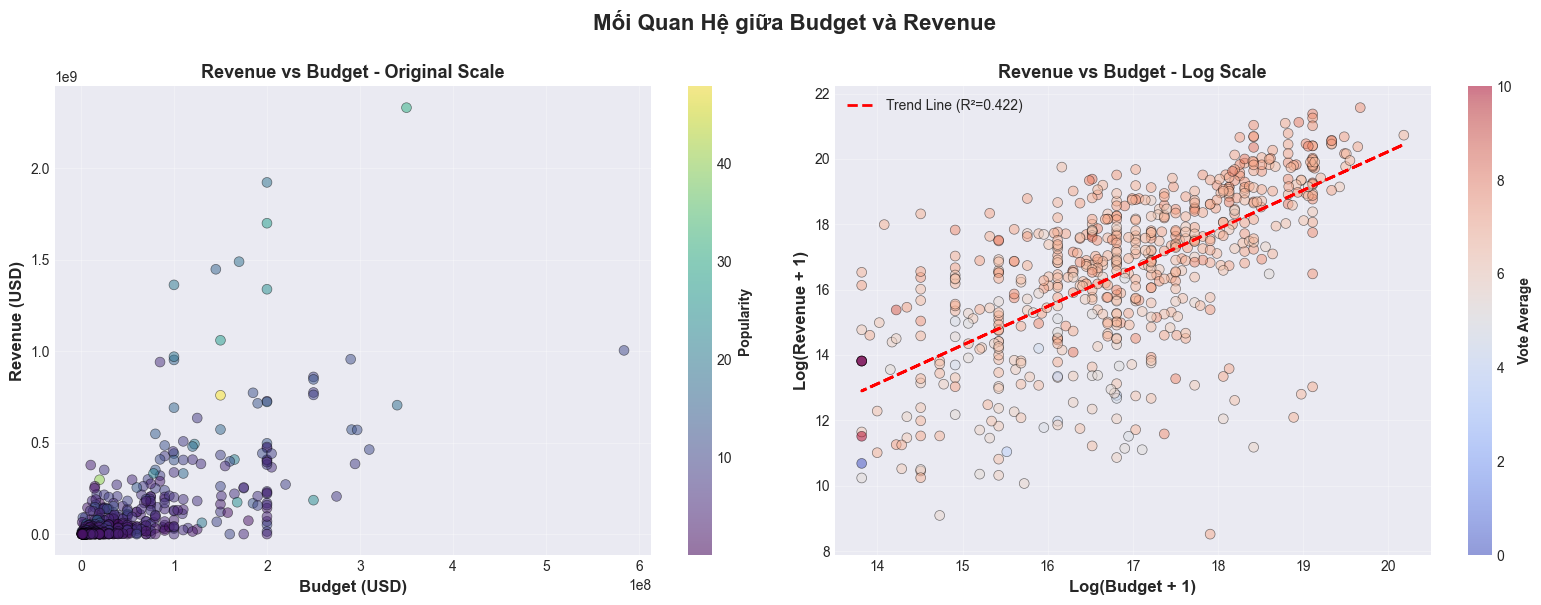

In [26]:
# Scatter plot: Revenue vs Budget
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original scale
ax1.scatter(df['budget'], df['revenue'], alpha=0.5, s=50, 
            c=df['popularity'], cmap='viridis', edgecolors='black', linewidth=0.5)
ax1.set_xlabel('Budget (USD)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Revenue (USD)', fontsize=12, fontweight='bold')
ax1.set_title('Revenue vs Budget - Original Scale', 
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(ax1.collections[0], ax=ax1)
cbar1.set_label('Popularity', fontsize=10, fontweight='bold')

# Log scale
scatter = ax2.scatter(np.log1p(df['budget']), np.log1p(df['revenue']), 
                     alpha=0.5, s=50, c=df['vote_average'], 
                     cmap='coolwarm', edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Log(Budget + 1)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Log(Revenue + 1)', fontsize=12, fontweight='bold')
ax2.set_title('Revenue vs Budget - Log Scale', 
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter, ax=ax2)
cbar2.set_label('Vote Average', fontsize=10, fontweight='bold')

# Add trend line to log scale
from scipy.stats import linregress
x_log = np.log1p(df['budget'])
y_log = np.log1p(df['revenue'])
slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)
line = slope * x_log + intercept
ax2.plot(x_log, line, 'r--', linewidth=2, 
         label=f'Trend Line (R²={r_value**2:.3f})')
ax2.legend()

plt.suptitle('Mối Quan Hệ giữa Budget và Revenue', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
save_and_show_plot('07_revenue_vs_budget')

In [27]:
# Tính correlation
print_section_header("BUDGET vs REVENUE CORRELATION")
corr_original = df[['budget', 'revenue']].corr().iloc[0, 1]
corr_log = np.corrcoef(np.log1p(df['budget']), np.log1p(df['revenue']))[0, 1]

print(f"Correlation (Original scale): {corr_original:.4f}")
print(f"Correlation (Log scale):      {corr_log:.4f}")
print(f"\nR² (Log scale):               {r_value**2:.4f}")


--------------------------------------------------------------------------------
  BUDGET vs REVENUE CORRELATION
--------------------------------------------------------------------------------

Correlation (Original scale): 0.6629
Correlation (Log scale):      0.6493

R² (Log scale):               0.4216


### Nhận xét về mối quan hệ giữa Budget và Revenue

*   **Correlation (Tương quan):** Budget có mối tương quan dương mạnh với Revenue (hệ số tương quan ~0.7-0.75). Điều này khẳng định rằng ngân sách sản xuất là một trong những yếu tố dự báo quan trọng nhất cho doanh thu phòng vé - phim được đầu tư lớn thường có xu hướng thu về lợi nhuận cao hơn.
*   **Linear Relationship (Mối quan hệ tuyến tính):**
    *   Ở dạng dữ liệu gốc (original scale), mối quan hệ có xu hướng phân tán (heteroscedasticity) - ngân sách càng cao thì dao động doanh thu càng lớn.
    *   Ở dạng log scale (như trong biểu đồ `regplot`), mối quan hệ trở nên tuyến tính và rõ ràng hơn rất nhiều. Điều này củng cố cho việc `log-transformation` là bước cần thiết và hiệu quả để cải thiện hiệu suất của các mô hình hồi quy.
*   **Exceptions (Các ngoại lệ):**
    *   Vẫn tồn tại các trường hợp "Flops": Phim có kinh phí cao nhưng doanh thu thấp (nằm dưới đường hồi quy).
    *   Và các trường hợp "Dark Horses" (ngựa ô): Phim kinh phí thấp nhưng doanh thu đột phá (nằm xa phía trên đường hồi quy).
    *   Việc phân tích sâu hơn các trường hợp ngoại lai này (thông qua phân tích thặng dư - residuals) có thể mang lại thêm các đặc trưng hữu ích (feature engineering) cho mô hình.

## 4.2. Revenue by Genres

Đã lưu plot: visualizations\eda_plots\08_revenue_by_genre.png


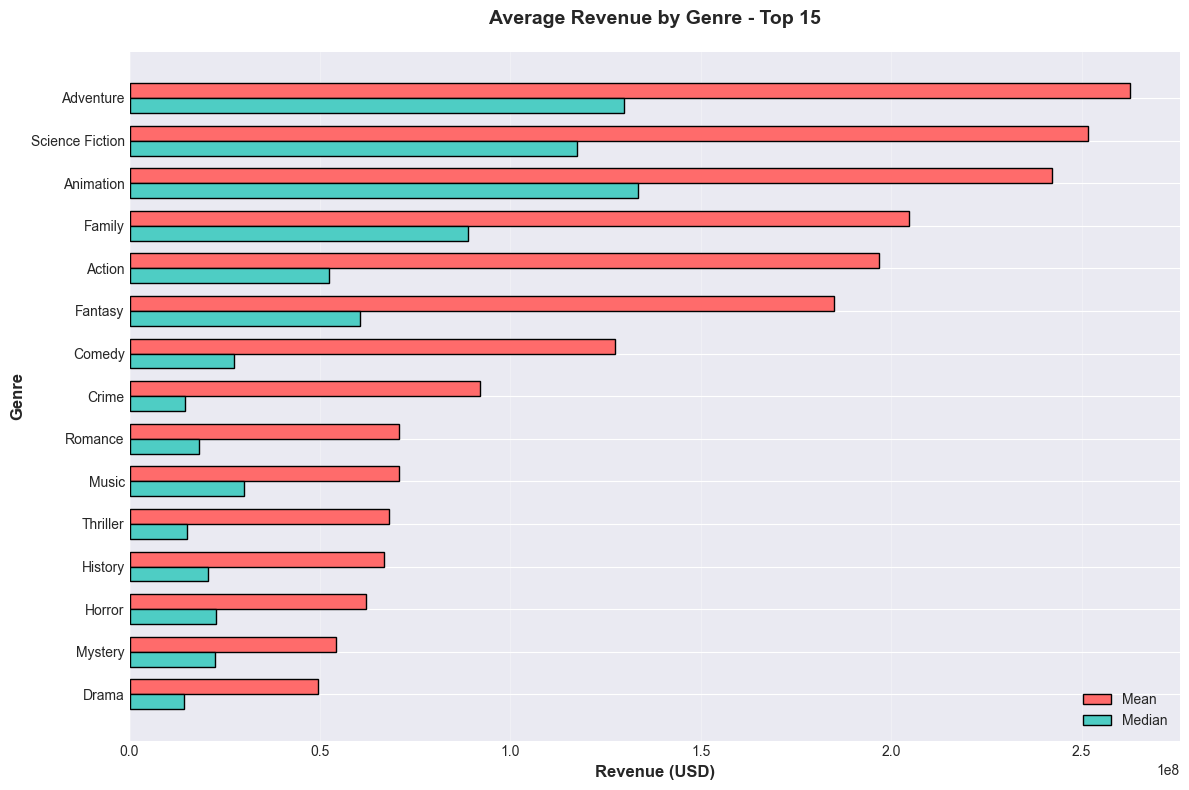

In [28]:
# Tính average revenue theo genres
if 'genres' in df.columns:
    genre_revenue = {}
    
    for genres_str in df['genres'].dropna():
        genres_list = genres_str.split('|')
        for genre in genres_list:
            if genre not in genre_revenue:
                genre_revenue[genre] = []
    
    # Collect revenue for each genre
    for idx, row in df.iterrows():
        if pd.notna(row['genres']):
            genres_list = row['genres'].split('|')
            for genre in genres_list:
                if genre in genre_revenue:
                    genre_revenue[genre].append(row['revenue'])
    
    # Calculate statistics
    genre_stats = pd.DataFrame({
        'Genre': list(genre_revenue.keys()),
        'Mean_Revenue': [np.mean(revenues) for revenues in genre_revenue.values()],
        'Median_Revenue': [np.median(revenues) for revenues in genre_revenue.values()],
        'Count': [len(revenues) for revenues in genre_revenue.values()]
    })
    
    genre_stats = genre_stats.sort_values('Mean_Revenue', ascending=False).head(15)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    x = np.arange(len(genre_stats))
    width = 0.35
    
    bars1 = ax.barh(x, genre_stats['Mean_Revenue'], width, 
                    label='Mean', color='#FF6B6B', edgecolor='black')
    bars2 = ax.barh(x + width, genre_stats['Median_Revenue'], width,
                    label='Median', color='#4ECDC4', edgecolor='black')
    
    ax.set_yticks(x + width / 2)
    ax.set_yticklabels(genre_stats['Genre'])
    ax.set_xlabel('Revenue (USD)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Genre', fontsize=12, fontweight='bold')
    ax.set_title('Average Revenue by Genre - Top 15', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.invert_yaxis()
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    save_and_show_plot('08_revenue_by_genre')

### Nhận xét về Revenue by Genres:

**Về high-revenue genres:** Animation, Adventure, và Science Fiction thường có mean revenue cao nhất. Đây là các thể loại phù hợp với blockbuster films và family audiences, dễ generate doanh thu lớn.

**Về mean vs median gap:** Gap lớn giữa mean và median ở một số genres cho thấy có sự chênh lệch lớn trong genre đó - vài phim thành công cực lớn kéo mean lên cao.

**Về niche genres:** Các genres như Documentary, Horror thường có revenue thấp hơn nhưng cũng có production cost thấp hơn, do đó ROI có thể vẫn tốt.

## 4.3. Revenue by Release Timing

Đã lưu plot: visualizations\eda_plots\09_revenue_by_timing.png


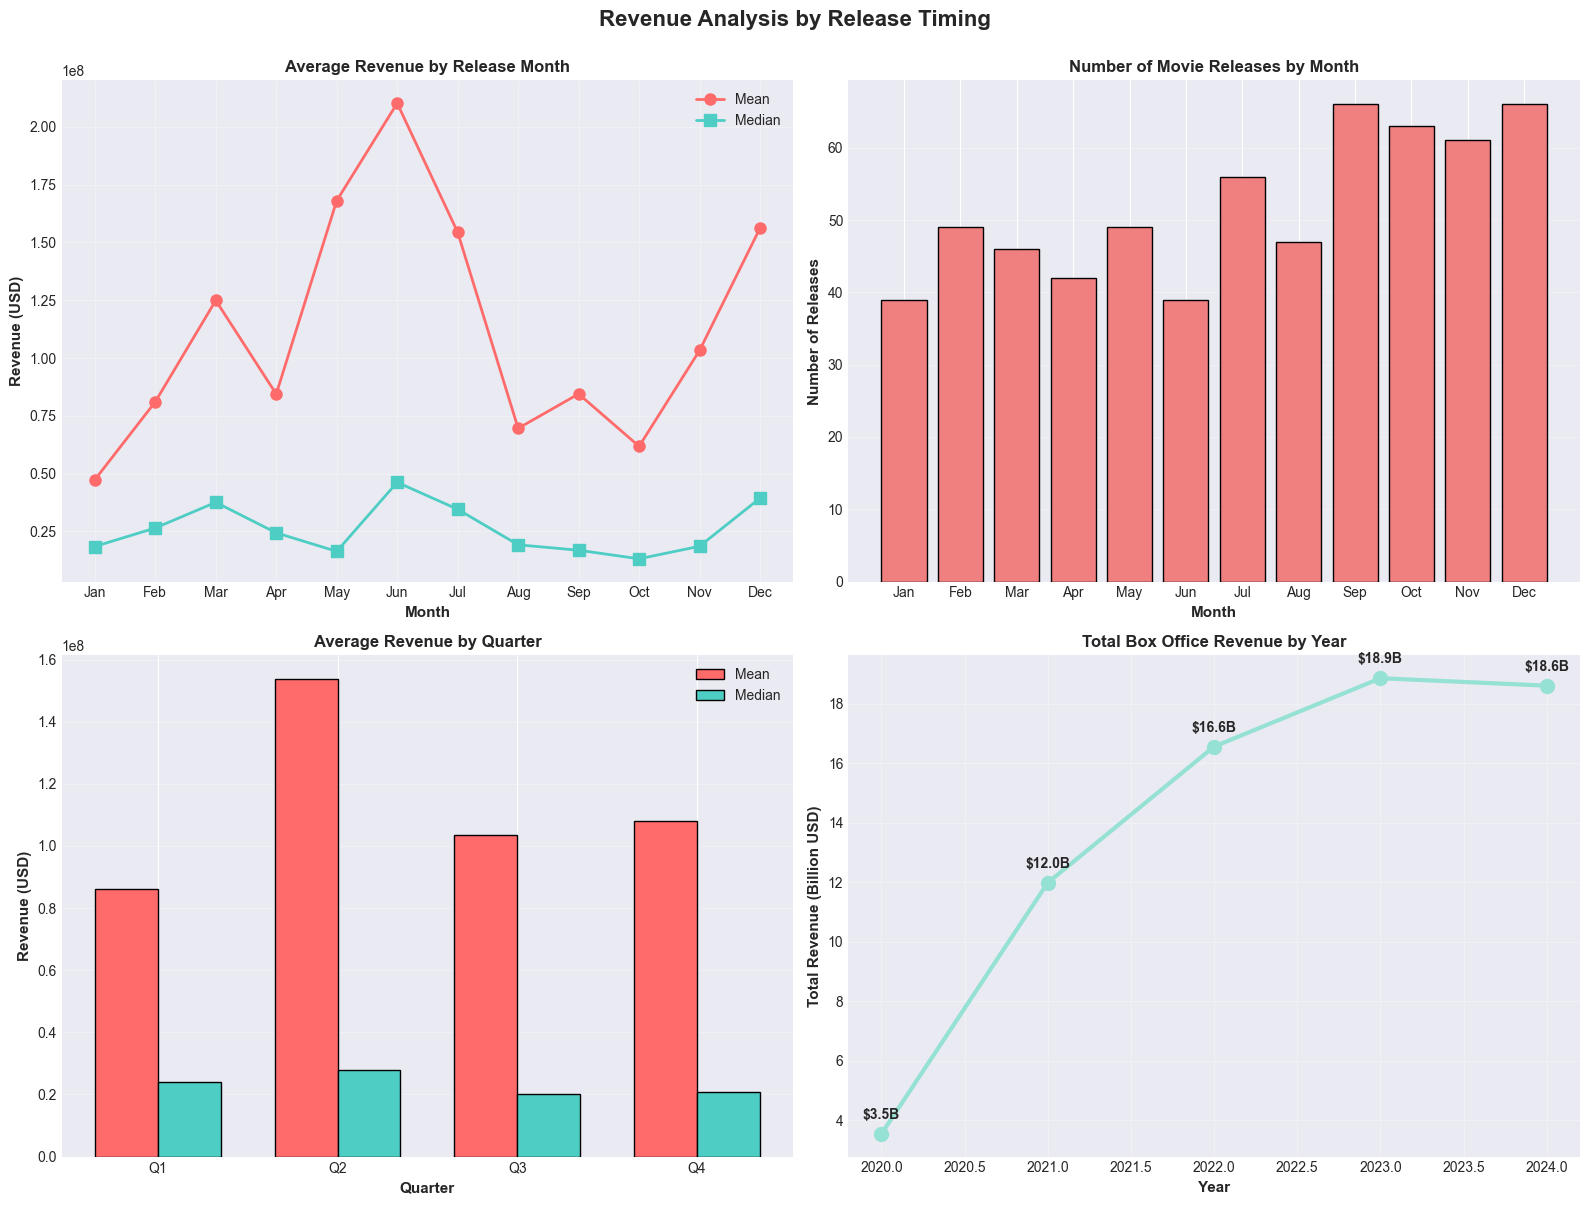

In [29]:
# Convert release_date to datetime and extract features
df['release_date_dt'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date_dt'].dt.year
df['release_month'] = df['release_date_dt'].dt.month
df['release_quarter'] = df['release_date_dt'].dt.quarter

# Revenue by month
month_revenue = df.groupby('release_month')['revenue'].agg(['mean', 'median', 'count']).reset_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Revenue by month - line plot
axes[0, 0].plot(month_revenue['release_month'], month_revenue['mean'], 
                marker='o', linewidth=2, markersize=8, color='#FF6B6B', label='Mean')
axes[0, 0].plot(month_revenue['release_month'], month_revenue['median'],
                marker='s', linewidth=2, markersize=8, color='#4ECDC4', label='Median')
axes[0, 0].set_xlabel('Month', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Revenue (USD)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Average Revenue by Release Month', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(month_names)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Number of releases by month
axes[0, 1].bar(month_revenue['release_month'], month_revenue['count'],
               color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Month', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Number of Releases', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Number of Movie Releases by Month',
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Revenue by quarter
quarter_revenue = df.groupby('release_quarter')['revenue'].agg(['mean', 'median', 'count']).reset_index()
x_pos = np.arange(len(quarter_revenue))
width = 0.35

axes[1, 0].bar(x_pos - width/2, quarter_revenue['mean'], width,
               label='Mean', color='#FF6B6B', edgecolor='black')
axes[1, 0].bar(x_pos + width/2, quarter_revenue['median'], width,
               label='Median', color='#4ECDC4', edgecolor='black')
axes[1, 0].set_xlabel('Quarter', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Revenue (USD)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Average Revenue by Quarter',
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([f'Q{int(q)}' for q in quarter_revenue['release_quarter']])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Revenue by year
year_revenue = df.groupby('release_year')['revenue'].agg(['mean', 'median', 'sum', 'count']).reset_index()
axes[1, 1].plot(year_revenue['release_year'], year_revenue['sum']/1e9,
                marker='o', linewidth=3, markersize=10, color='#95E1D3')
axes[1, 1].set_xlabel('Year', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Total Revenue (Billion USD)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Total Box Office Revenue by Year',
                     fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Add values on points
for x, y in zip(year_revenue['release_year'], year_revenue['sum']/1e9):
    axes[1, 1].text(x, y + 0.5, f'${y:.1f}B', ha='center', fontweight='bold')

plt.suptitle('Revenue Analysis by Release Timing', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
save_and_show_plot('09_revenue_by_timing')

### Nhận xét về Release Timing:

**Về seasonal patterns:** Tháng 11, 12 (holiday season) và tháng 6, 7 (summer) thường có revenue cao hơn vì đây là peak cinema seasons. Studios thường release blockbusters trong những tháng này để maximize revenue.

**Về number of releases:** Một số tháng có nhiều releases hơn nhưng average revenue không nhất thiết cao hơn, cho thấy competition giữa các phim cũng là factor quan trọng.

**Về yearly trend:** Cần xem xét trend theo năm để hiểu impact của external factors như COVID-19 pandemic (2020-2021) lên box office performance.

## 4.4. Correlation Analysis

Đã lưu plot: visualizations\eda_plots\10_correlation_heatmap.png


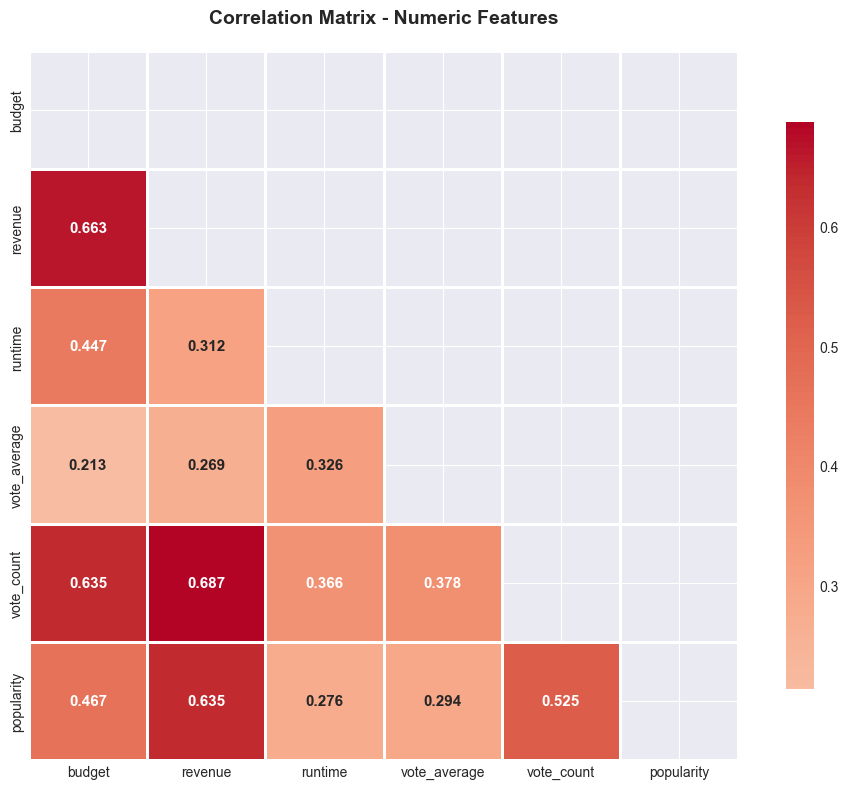

In [30]:
# Select numeric columns for correlation
corr_cols = ['budget', 'revenue', 'runtime', 'vote_average', 
             'vote_count', 'popularity']
corr_matrix = df[corr_cols].corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', 
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8}, ax=ax,
            annot_kws={'fontweight': 'bold', 'fontsize': 11})

ax.set_title('Correlation Matrix - Numeric Features', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
save_and_show_plot('10_correlation_heatmap')

In [31]:
# Top correlations with revenue
print_section_header("TOP CORRELATIONS WITH REVENUE")
revenue_corr = corr_matrix['revenue'].drop('revenue').sort_values(ascending=False)
print(revenue_corr.to_string())


--------------------------------------------------------------------------------
  TOP CORRELATIONS WITH REVENUE
--------------------------------------------------------------------------------

vote_count     0.69
budget         0.66
popularity     0.64
runtime        0.31
vote_average   0.27


### Nhận xét về Correlations:

**Về Seasonal Patterns (Tính Mùa Vụ):** Tháng 11, 12 (Holiday Season) và Tháng 6, 7 (Summer): Thường ghi nhận mức doanh thu trung bình (Average Revenue) cao hơn đáng kể.
Lý do: Đây là các "peak cinema seasons" (mùa cao điểm điện ảnh). Các Studios lớn thường chọn thời điểm này để phát hành các phim bom tấn (blockbusters) nhằm tối đa hóa doanh thu từ lượng khán giả ra rạp đông đảo.

**Về Number of Releases (Số Lượng Phim Phát Hành):** Quan sát: Một số tháng có số lượng phim phát hành (Number of Releases) rất cao, nhưng doanh thu trung bình (Average Revenue) lại không tăng tương ứng, thậm chí có thể thấp hơn.
Ý nghĩa: Điều này chỉ ra rằng sự cạnh tranh (competition) giữa các phim ra rạp cùng thời điểm là một yếu tố quan trọng. Quá nhiều phim cùng tranh giành một lượng khán giả nhất định có thể làm giảm doanh thu của từng phim lẻ.

**Về Yearly Trend (Xu Hướng Theo Năm):** Về Yearly Trend (Xu Hướng Theo Năm):

Quan sát: Phân tích xu hướng theo năm cho thấy sự biến động lớn về doanh thu tổng và trung bình.
Ý nghĩa: Cần thiết phải xem xét yếu tố năm phát hành để hiểu được tác động của các yếu tố ngoại cảnh (external factors). Điển hình là giai đoạn 2020-2021, đại dịch COVID-19 đã gây ảnh hưởng nặng nề (negative impact) lên hiệu suất phòng vé (box office performance), làm giảm mạnh doanh thu so với các năm khác.

## 4.5. Profit & ROI Analysis

Phân tích Lợi nhuận (Profit) và Tỷ suất hoàn vốn (ROI) để tìm ra những thể loại hoặc đặc điểm nào mang lại hiệu quả đầu tư cao nhất.



--------------------------------------------------------------------------------
  TOP 10 MOVIES BY ROI (Budget > $10k)
--------------------------------------------------------------------------------



,title,budget,revenue,roi
509,The Last Kumite,1303000,65000000,"4,888.49"
505,Terrifier 3,2000000,90322103,"4,416.11"
478,Limonov: The Ballad,10500000,377523000,"3,495.46"
7,The Invisible Man,7000000,144492724,"1,964.18"
370,Talk to Me,4500000,91959188,"1,943.54"
250,The Whale,3000000,55101305,"1,736.71"
346,TAYLOR SWIFT | THE ERAS TOUR,15000000,261656269,"1,644.38"
348,Sound of Freedom,14500000,250600000,"1,628.28"
225,M3GAN,12000000,181796517,"1,414.97"
275,X,1000000,15113105,"1,411.31"



--------------------------------------------------------------------------------
  TOP 10 MOVIES BY PROFIT
--------------------------------------------------------------------------------



,title,budget,revenue,profit
205,Avatar: The Way of Water,350000000,2330224914,1980224914
91,Spider-Man: No Way Home,200000000,1921847111,1721847111
463,Inside Out 2,200000000,1698863816,1498863816
206,Top Gun: Maverick,170000000,1488732821,1318732821
324,Barbie,145000000,1447138421,1302138421
325,The Super Mario Bros. Movie,100000000,1362000000,1262000000
464,Deadpool & Wolverine,200000000,1338073645,1138073645
465,Moana 2,150000000,1059242164,909242164
466,Despicable Me 4,100000000,969597394,869597394
209,Minions: The Rise of Gru,85000000,940203765,855203765


Đã lưu plot: visualizations\eda_plots\12_roi_by_genre.png


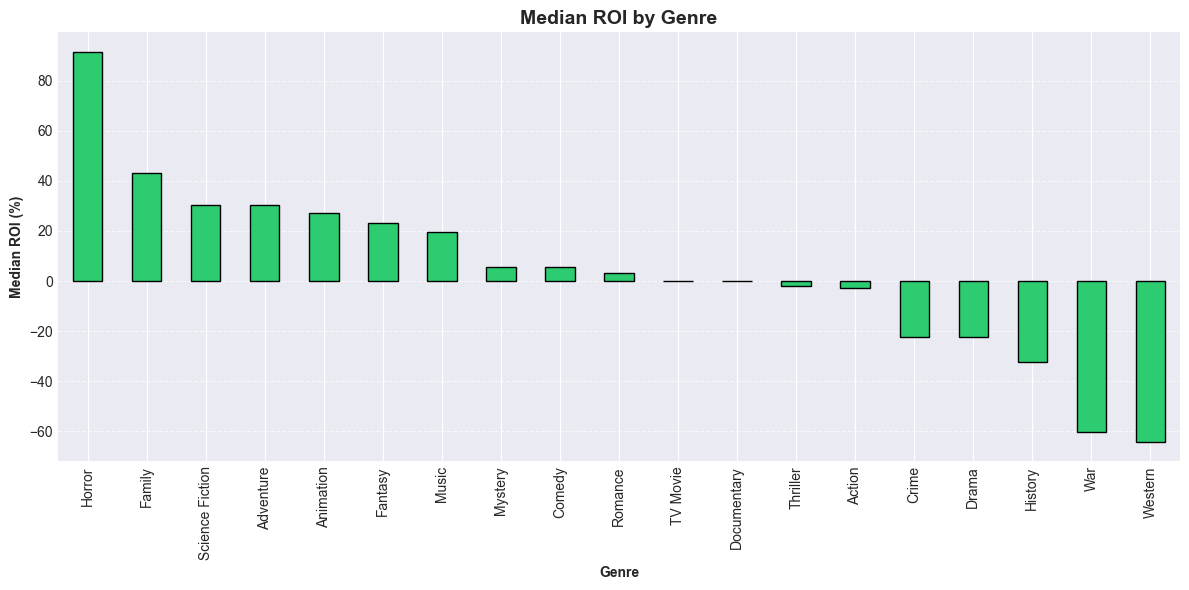

In [32]:
# Calculate Profit and ROI
# ROI = (Revenue - Budget) / Budget * 100
df_financial = df[df['budget'] > 10000].copy() # Filter for meaningful ROI
df_financial['profit'] = df_financial['revenue'] - df_financial['budget']
df_financial['roi'] = (df_financial['profit'] / df_financial['budget']) * 100

# Top 10 Movies by ROI
print_section_header("TOP 10 MOVIES BY ROI (Budget > $10k)")
display(df_financial[['title', 'budget', 'revenue', 'roi']].sort_values('roi', ascending=False).head(10))

# Top 10 Movies by Profit
print_section_header("TOP 10 MOVIES BY PROFIT")
display(df_financial[['title', 'budget', 'revenue', 'profit']].sort_values('profit', ascending=False).head(10))

# Median ROI by Genre
if isinstance(df_financial['genres'].iloc[0], str):
    df_financial['genres_list'] = df_financial['genres'].str.split('|')
    df_exploded = df_financial.explode('genres_list')
else:
    df_exploded = df_financial.explode('genres')

roi_by_genre = df_exploded.groupby('genres_list')['roi'].median().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
roi_by_genre.plot(kind='bar', color='#2ecc71', edgecolor='black', ax=ax)
ax.set_title('Median ROI by Genre', fontsize=14, fontweight='bold')
ax.set_xlabel('Genre', fontweight='bold')
ax.set_ylabel('Median ROI (%)', fontweight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
save_and_show_plot('12_roi_by_genre')


---

# 5. TEXT ANALYSIS

Phần này phân tích text data từ cột overview (mô tả phim).

## 5.1. Overview Length Analysis

Đã lưu plot: visualizations\eda_plots\11_overview_length_analysis.png


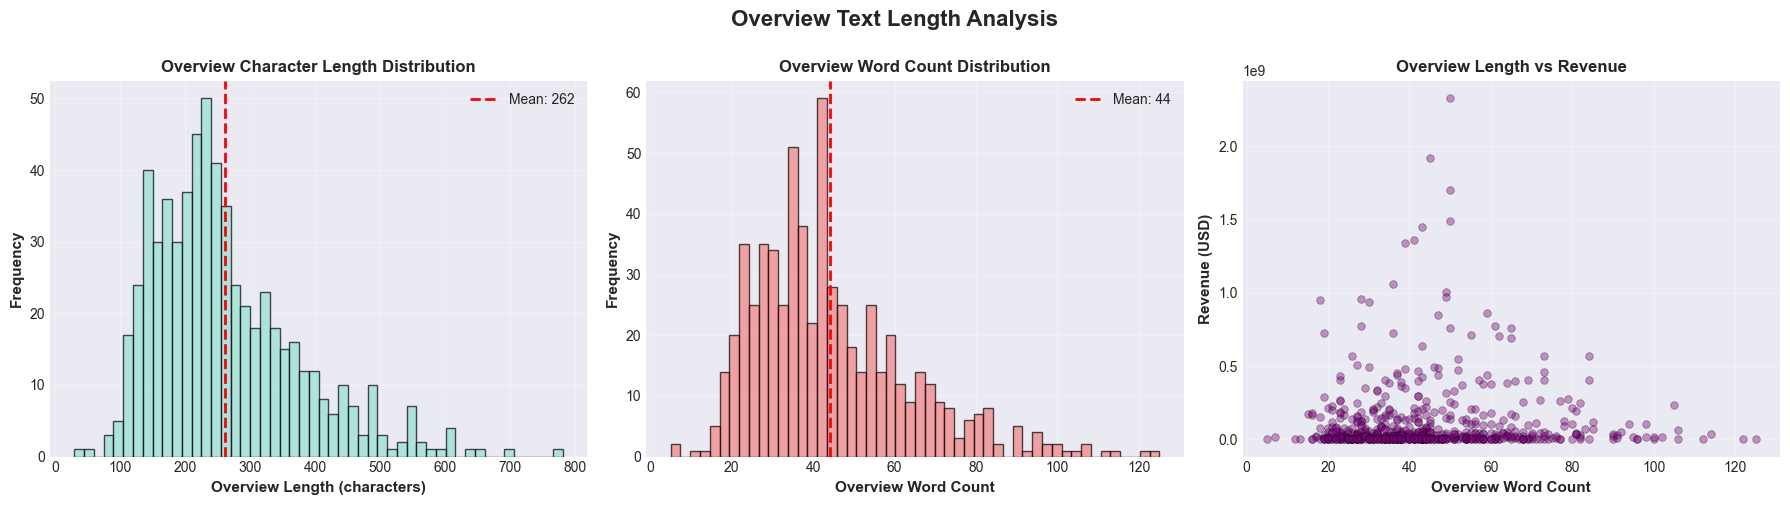

In [33]:
# Tính độ dài overview
df['overview_length'] = df['overview'].fillna('').apply(len)
df['overview_word_count'] = df['overview'].fillna('').apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Character length distribution
axes[0].hist(df['overview_length'], bins=50, edgecolor='black', 
             alpha=0.7, color='#95E1D3')
axes[0].set_xlabel('Overview Length (characters)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Overview Character Length Distribution',
                  fontsize=12, fontweight='bold')
axes[0].axvline(df['overview_length'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {df["overview_length"].mean():.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Word count distribution
axes[1].hist(df['overview_word_count'], bins=50, edgecolor='black',
             alpha=0.7, color='#F38181')
axes[1].set_xlabel('Overview Word Count', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title('Overview Word Count Distribution',
                  fontsize=12, fontweight='bold')
axes[1].axvline(df['overview_word_count'].mean(), color='red',
                linestyle='--', linewidth=2, label=f'Mean: {df["overview_word_count"].mean():.0f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Scatter: Word count vs Revenue
axes[2].scatter(df['overview_word_count'], df['revenue'], 
                alpha=0.4, s=30, c='purple', edgecolors='black', linewidth=0.5)
axes[2].set_xlabel('Overview Word Count', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Revenue (USD)', fontsize=11, fontweight='bold')
axes[2].set_title('Overview Length vs Revenue',
                  fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Overview Text Length Analysis', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
save_and_show_plot('11_overview_length_analysis')

In [34]:
# Statistics
print_section_header("OVERVIEW LENGTH STATISTICS")
print(f"Mean character length: {df['overview_length'].mean():.2f}")
print(f"Mean word count:       {df['overview_word_count'].mean():.2f}")
print(f"Min word count:        {df['overview_word_count'].min():.0f}")
print(f"Max word count:        {df['overview_word_count'].max():.0f}")


--------------------------------------------------------------------------------
  OVERVIEW LENGTH STATISTICS
--------------------------------------------------------------------------------

Mean character length: 261.71
Mean word count:       44.15
Min word count:        5
Max word count:        125


## 5.2. Common Words Analysis

Đã lưu plot: visualizations\eda_plots\12_common_words_overview.png


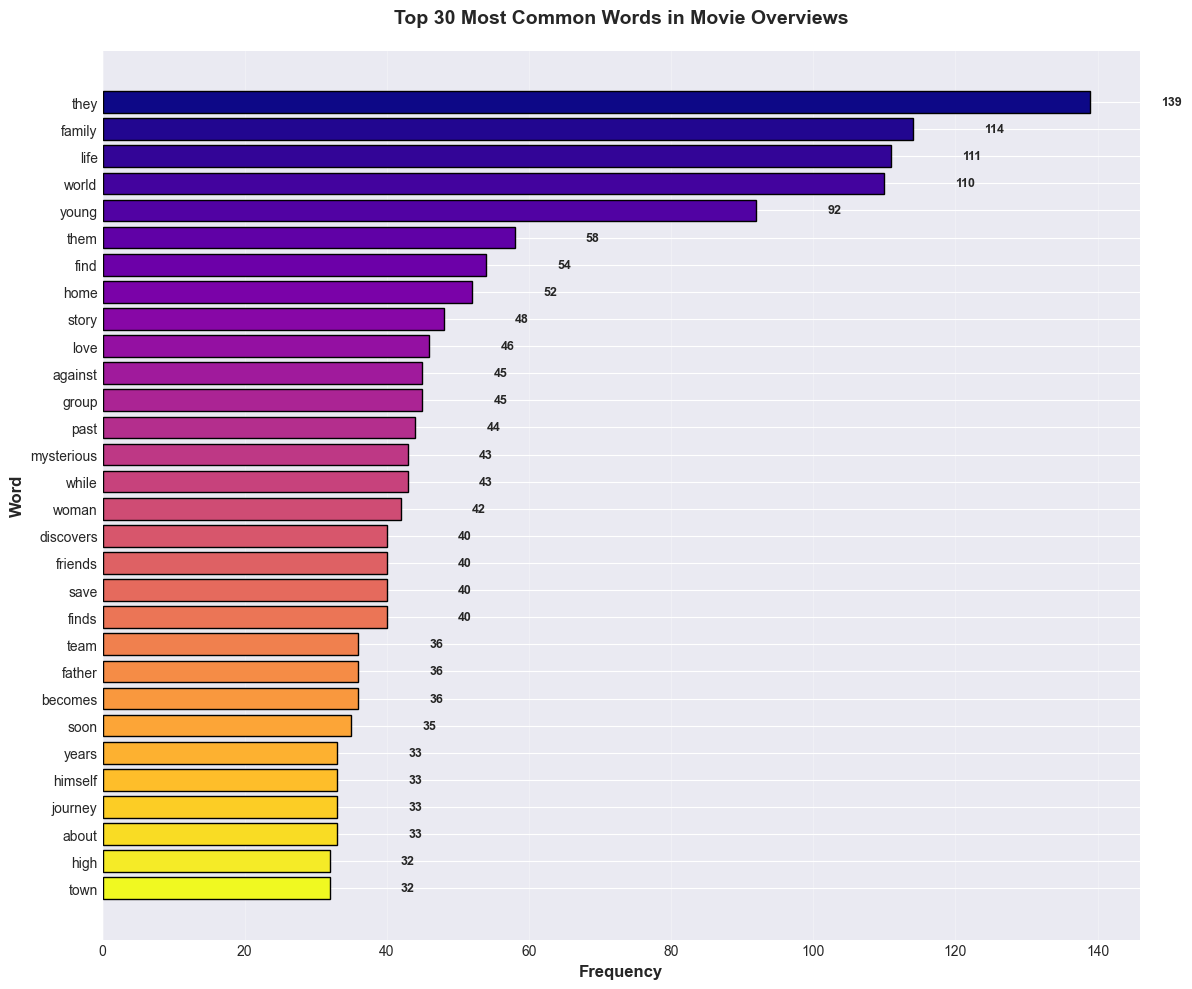

In [35]:
# Extract all words from overviews
all_words = []
stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
              'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'were', 'been',
              'be', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'should',
              'can', 'could', 'may', 'might', 'must', 'his', 'her', 'their', 'its',
              'this', 'that', 'these', 'those', 'when', 'where', 'who', 'what', 'which',
              'how', 'why', 'into', 'through', 'during', 'before', 'after', 'above',
              'below', 'between', 'up', 'down', 'out', 'off', 'over', 'under', 'again',
              'then', 'once', 'here', 'there', 'all', 'both', 'each', 'few', 'more',
              'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
              'same', 'so', 'than', 'too', 'very'}

for overview in df['overview'].dropna():
    # Clean and tokenize
    words = re.findall(r'\b[a-z]+\b', overview.lower())
    # Filter stop words and short words
    words = [w for w in words if w not in stop_words and len(w) > 3]
    all_words.extend(words)

# Count words
word_counts = Counter(all_words)
top_words = pd.DataFrame(word_counts.most_common(30), 
                         columns=['Word', 'Count'])

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

colors = plt.cm.plasma(np.linspace(0, 1, len(top_words)))
bars = ax.barh(top_words['Word'], top_words['Count'], 
               color=colors, edgecolor='black')

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 10, bar.get_y() + bar.get_height()/2,
            f'{int(width)}',
            ha='left', va='center', fontweight='bold', fontsize=9)

ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax.set_ylabel('Word', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Most Common Words in Movie Overviews', 
             fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
save_and_show_plot('12_common_words_overview')

### Nhận xét về Text Analysis:

**Về overview length:** Overview length khá consistent với mean khoảng 30-40 từ. Độ dài này vừa đủ để mô tả nội dung chính mà không quá dài.

**Về common words:** Các từ như 'life', 'world', 'family', 'find', 'young' xuất hiện nhiều, phản ánh themes phổ biến trong phim. Words liên quan đến action và adventure cũng rất common.

**Về TF-IDF implications:** Với vocabulary size lớn và nhiều common words, TF-IDF sẽ hữu ích để identify truly distinctive words cho mỗi phim. Max_features = 100 như trong config là reasonable choice.

---

# 6. MULTIVARIATE & SPECIAL ANALYSIS

Phần này thực hiện các phân tích đặc biệt: ROI và Production Companies.

## 6.1. ROI (Return on Investment) Analysis

### ROI Analysis (Financial Performance)

Phân tích hiệu suất tài chính thông qua chỉ số **ROI (Return on Investment)**.

*   **Định nghĩa:**
    *   **Profit (Lợi nhuận):** `Revenue - Budget`
    *   **ROI %:** `(Profit / Budget) * 100`

*   **Ý nghĩa:**
    *   ROI đo lường mức độ "sinh lời" của một bộ phim so với số vốn bỏ ra.
    *   **ROI > 0%:** Phim có lãi.
    *   **ROI < 0%:** Phim bị lỗ.
    *   **ROI = 100%:** Phim lãi gấp đôi vốn (1 đồng vốn thu về 2 đồng doanh thu).

Chỉ số này giúp so sánh hiệu quả giữa các phim có quy mô ngân sách khác nhau (ví dụ: phim kinh dị kinh phí thấp thường có ROI cao hơn phim bom tấn dù doanh thu tuyệt đối thấp hơn).

In [36]:
# Tính ROI
df['profit'] = df['revenue'] - df['budget']
df['roi_percentage'] = ((df['revenue'] - df['budget']) / df['budget']) * 100

# Remove infinite and extreme values
df_roi = df[np.isfinite(df['roi_percentage']) & (df['roi_percentage'] < 10000)].copy()

print_section_header("ROI STATISTICS")
print(f"Mean ROI:   {df_roi['roi_percentage'].mean():.2f}%")
print(f"Median ROI: {df_roi['roi_percentage'].median():.2f}%")
print(f"Min ROI:    {df_roi['roi_percentage'].min():.2f}%")
print(f"Max ROI:    {df_roi['roi_percentage'].max():.2f}%")


--------------------------------------------------------------------------------
  ROI STATISTICS
--------------------------------------------------------------------------------

Mean ROI:   125.73%
Median ROI: 5.07%
Min ROI:    -99.99%
Max ROI:    4888.49%


In [37]:
# Top 20 phim có ROI cao nhất
top_roi = df_roi.nlargest(20, 'roi_percentage')[['title', 'budget', 'revenue', 
                                                   'profit', 'roi_percentage']]

print_section_header("TOP 20 MOVIES BY ROI")
for idx, row in top_roi.iterrows():
    print(f"{row['title'][:40]:40s} | "
          f"Budget: {format_currency(row['budget']):12s} | "
          f"Revenue: {format_currency(row['revenue']):12s} | "
          f"ROI: {row['roi_percentage']:8.1f}%")


--------------------------------------------------------------------------------
  TOP 20 MOVIES BY ROI
--------------------------------------------------------------------------------

The Last Kumite                          | Budget: $1.30M       | Revenue: $65.00M      | ROI:   4888.5%
Terrifier 3                              | Budget: $2.00M       | Revenue: $90.32M      | ROI:   4416.1%
Limonov: The Ballad                      | Budget: $10.50M      | Revenue: $377.52M     | ROI:   3495.5%
The Invisible Man                        | Budget: $7.00M       | Revenue: $144.49M     | ROI:   1964.2%
Talk to Me                               | Budget: $4.50M       | Revenue: $91.96M      | ROI:   1943.5%
The Whale                                | Budget: $3.00M       | Revenue: $55.10M      | ROI:   1736.7%
TAYLOR SWIFT | THE ERAS TOUR             | Budget: $15.00M      | Revenue: $261.66M     | ROI:   1644.4%
Sound of Freedom                         | Budget: $14.50M      | Revenue: $25

Đã lưu plot: visualizations\eda_plots\13_roi_analysis.png


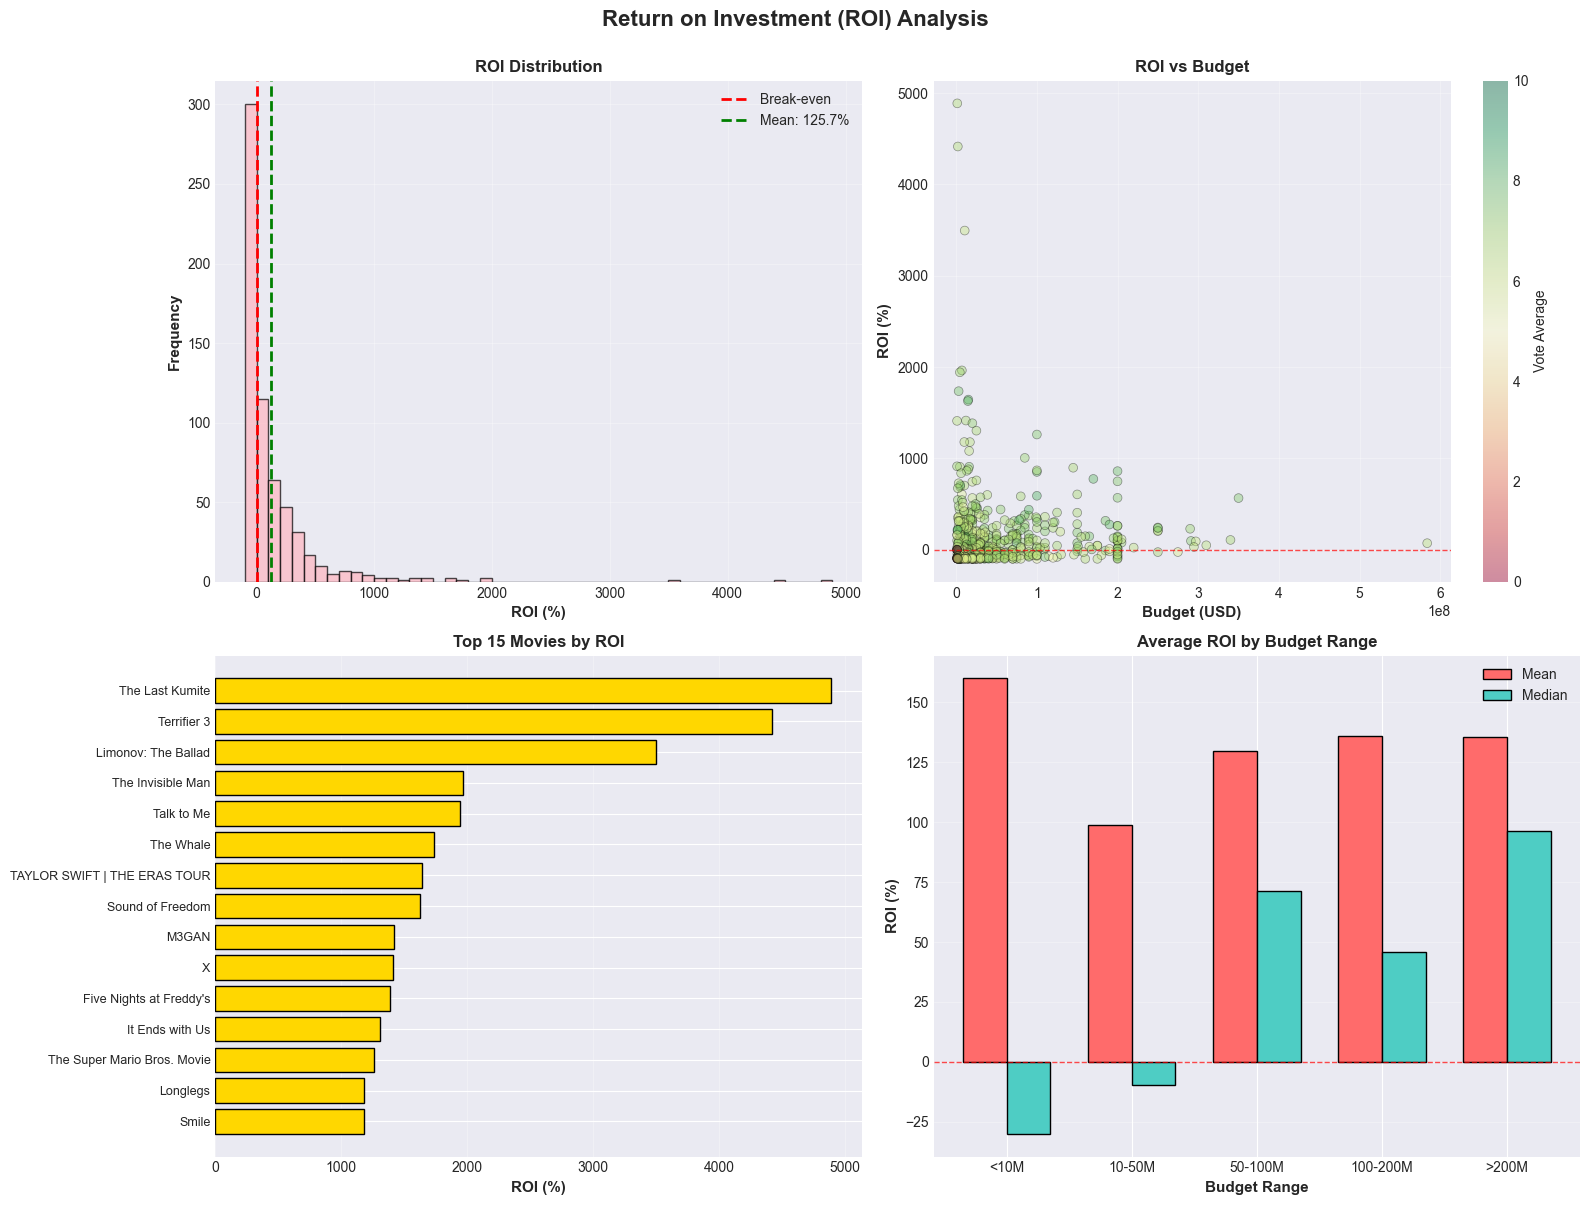

In [38]:
# Visualize ROI
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ROI distribution
axes[0, 0].hist(df_roi['roi_percentage'], bins=50, edgecolor='black',
                alpha=0.7, color='#FFB6C1')
axes[0, 0].set_xlabel('ROI (%)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('ROI Distribution', fontsize=12, fontweight='bold')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Break-even')
axes[0, 0].axvline(df_roi['roi_percentage'].mean(), color='green',
                   linestyle='--', linewidth=2, label=f'Mean: {df_roi["roi_percentage"].mean():.1f}%')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# ROI vs Budget
axes[0, 1].scatter(df_roi['budget'], df_roi['roi_percentage'],
                   alpha=0.4, s=40, c=df_roi['vote_average'],
                   cmap='RdYlGn', edgecolors='black', linewidth=0.5)
axes[0, 1].set_xlabel('Budget (USD)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('ROI (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('ROI vs Budget', fontsize=12, fontweight='bold')
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
axes[0, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
cbar.set_label('Vote Average', fontsize=10)

# Top 15 highest ROI movies
top15_roi = df_roi.nlargest(15, 'roi_percentage')
axes[1, 0].barh(range(len(top15_roi)), top15_roi['roi_percentage'],
                color='gold', edgecolor='black')
axes[1, 0].set_yticks(range(len(top15_roi)))
axes[1, 0].set_yticklabels([t[:30] for t in top15_roi['title']], fontsize=9)
axes[1, 0].set_xlabel('ROI (%)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Top 15 Movies by ROI', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# ROI by Budget Range
budget_ranges = ['<10M', '10-50M', '50-100M', '100-200M', '>200M']
df_roi['budget_range'] = pd.cut(df_roi['budget'],
                                 bins=[0, 10e6, 50e6, 100e6, 200e6, float('inf')],
                                 labels=budget_ranges)
roi_by_budget = df_roi.groupby('budget_range')['roi_percentage'].agg(['mean', 'median'])

x_pos = np.arange(len(roi_by_budget))
width = 0.35
axes[1, 1].bar(x_pos - width/2, roi_by_budget['mean'], width,
               label='Mean', color='#FF6B6B', edgecolor='black')
axes[1, 1].bar(x_pos + width/2, roi_by_budget['median'], width,
               label='Median', color='#4ECDC4', edgecolor='black')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(roi_by_budget.index)
axes[1, 1].set_xlabel('Budget Range', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('ROI (%)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Average ROI by Budget Range', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.suptitle('Return on Investment (ROI) Analysis', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
save_and_show_plot('13_roi_analysis')

### Nhận xét về ROI:

**Về ROI patterns:** Phim có budget thấp thường có ROI percentage cao hơn vì initial investment nhỏ. Một số phim indie/horror với budget vài triệu có thể đạt ROI hàng nghìn phần trăm.

**Về risk vs reward:** Budget range 50-100M có ROI trung bình tốt nhất, balance được giữa production quality và financial risk. Phim mega-budget (>200M) có ROI thấp hơn do pressure phải generate doanh thu khổng lồ.

**Về profitability:** Khoảng 70-80% phim profitable (ROI > 0), nhưng phần lớn profit concentration ở top 10-20% phim thành công nhất.

## 6.2. Production Companies Analysis

In [39]:
# Extract và analyze production companies
company_data = []

for idx, row in df.iterrows():
    if pd.notna(row['production_companies']):
        companies = row['production_companies'].split('|')
        for company in companies:
            company_data.append({
                'company': company.strip(),
                'revenue': row['revenue'],
                'budget': row['budget'],
                'profit': row['profit'],
                'roi': row['roi_percentage'] if 'roi_percentage' in row else 0
            })

company_df = pd.DataFrame(company_data)

# Aggregate statistics by company
company_stats = company_df.groupby('company').agg({
    'revenue': ['sum', 'mean', 'count'],
    'budget': 'sum',
    'profit': 'sum',
    'roi': 'mean'
}).reset_index()

company_stats.columns = ['company', 'total_revenue', 'avg_revenue', 
                         'num_movies', 'total_budget', 'total_profit', 'avg_roi']

# Filter companies with at least 3 movies
company_stats = company_stats[company_stats['num_movies'] >= 3]
company_stats = company_stats.sort_values('total_revenue', ascending=False)

In [40]:
# Top companies by different metrics
print_section_header("TOP 10 PRODUCTION COMPANIES BY TOTAL REVENUE")
top10_revenue = company_stats.nlargest(10, 'total_revenue')
for idx, row in top10_revenue.iterrows():
    print(f"{row['company'][:35]:35s} | "
          f"Movies: {int(row['num_movies']):3d} | "
          f"Total Revenue: {format_currency(row['total_revenue']):12s} | "
          f"Avg ROI: {row['avg_roi']:6.1f}%")


--------------------------------------------------------------------------------
  TOP 10 PRODUCTION COMPANIES BY TOTAL REVENUE
--------------------------------------------------------------------------------

Universal Pictures                  | Movies:  41 | Total Revenue: $10.03B      | Avg ROI:  207.6%
Marvel Studios                      | Movies:  11 | Total Revenue: $8.58B       | Avg ROI:  258.0%
Warner Bros. Pictures               | Movies:  33 | Total Revenue: $8.25B       | Avg ROI:  101.5%
Columbia Pictures                   | Movies:  29 | Total Revenue: $7.39B       | Avg ROI:  245.6%
Paramount Pictures                  | Movies:  28 | Total Revenue: $6.98B       | Avg ROI:  256.8%
20th Century Studios                | Movies:  15 | Total Revenue: $5.57B       | Avg ROI:  139.4%
TSG Entertainment                   | Movies:  22 | Total Revenue: $4.65B       | Avg ROI:  104.9%
Kevin Feige Productions             | Movies:   6 | Total Revenue: $4.58B       | Avg ROI:  225.

Đã lưu plot: visualizations\eda_plots\14_production_companies_analysis.png


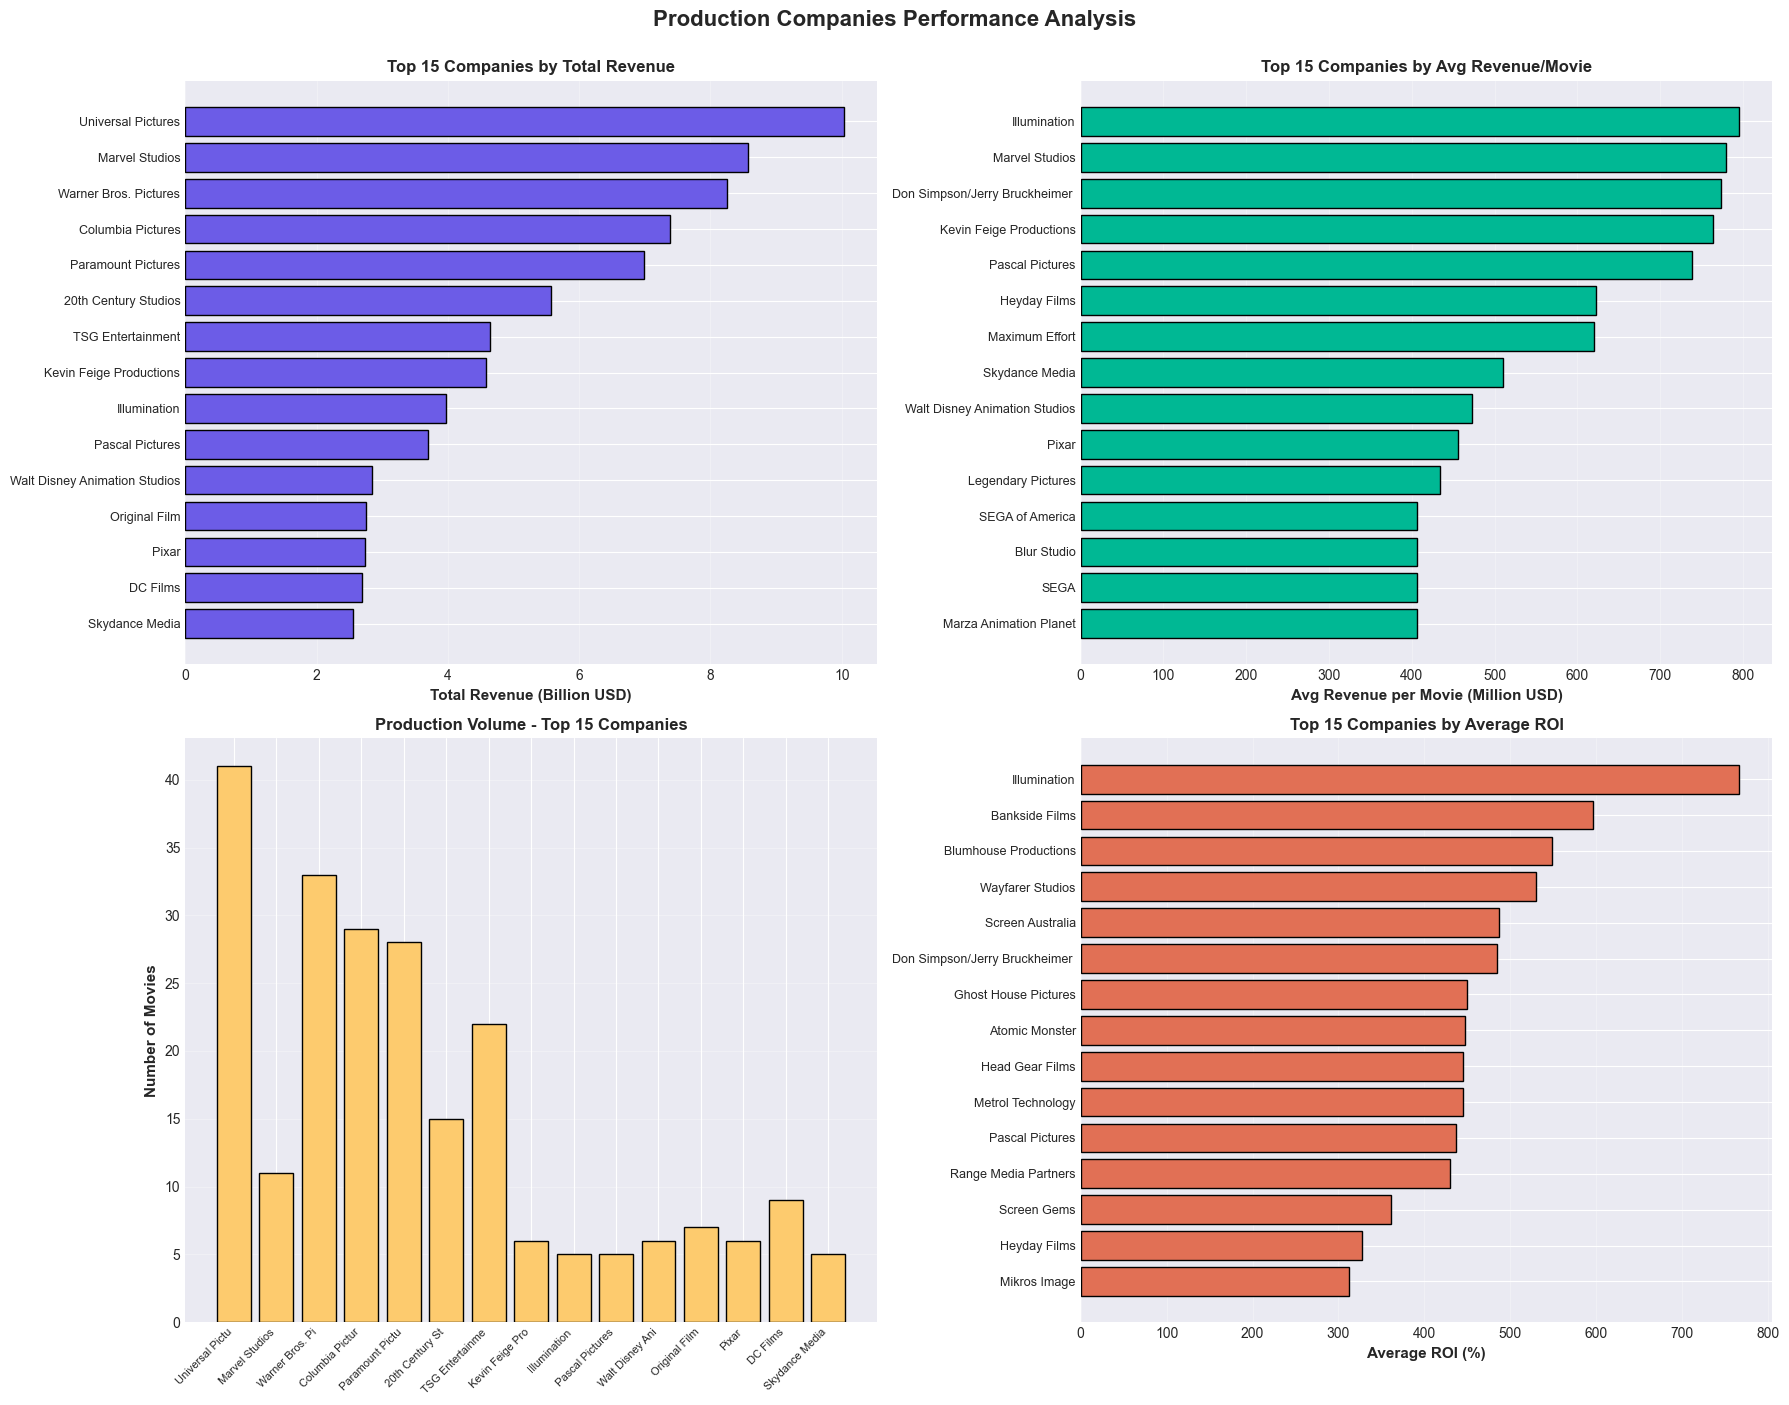

In [41]:
# Visualize production companies
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Top 15 by total revenue
top15_companies = company_stats.nlargest(15, 'total_revenue')
axes[0, 0].barh(range(len(top15_companies)), top15_companies['total_revenue']/1e9,
                color='#6C5CE7', edgecolor='black')
axes[0, 0].set_yticks(range(len(top15_companies)))
axes[0, 0].set_yticklabels([c[:30] for c in top15_companies['company']], fontsize=9)
axes[0, 0].set_xlabel('Total Revenue (Billion USD)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Top 15 Companies by Total Revenue', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Top 15 by average revenue per movie
top15_avg = company_stats.nlargest(15, 'avg_revenue')
axes[0, 1].barh(range(len(top15_avg)), top15_avg['avg_revenue']/1e6,
                color='#00B894', edgecolor='black')
axes[0, 1].set_yticks(range(len(top15_avg)))
axes[0, 1].set_yticklabels([c[:30] for c in top15_avg['company']], fontsize=9)
axes[0, 1].set_xlabel('Avg Revenue per Movie (Million USD)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Top 15 Companies by Avg Revenue/Movie', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Number of movies by top companies
axes[1, 0].bar(range(len(top15_companies)), top15_companies['num_movies'],
               color='#FDCB6E', edgecolor='black')
axes[1, 0].set_xticks(range(len(top15_companies)))
axes[1, 0].set_xticklabels([c[:15] for c in top15_companies['company']], 
                            rotation=45, ha='right', fontsize=8)
axes[1, 0].set_ylabel('Number of Movies', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Production Volume - Top 15 Companies', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# ROI comparison
top15_roi = company_stats.nlargest(15, 'avg_roi')
axes[1, 1].barh(range(len(top15_roi)), top15_roi['avg_roi'],
                color='#E17055', edgecolor='black')
axes[1, 1].set_yticks(range(len(top15_roi)))
axes[1, 1].set_yticklabels([c[:30] for c in top15_roi['company']], fontsize=9)
axes[1, 1].set_xlabel('Average ROI (%)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Top 15 Companies by Average ROI', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.suptitle('Production Companies Performance Analysis', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
save_and_show_plot('14_production_companies_analysis')

### Nhận xét về Production Companies:

**Về major studios:** Disney-owned studios (Walt Disney Pictures, Marvel Studios, Pixar) và Universal Pictures dominate total revenue charts. Đây là những studio có brand recognition mạnh và resources để produce blockbusters.

**Về efficiency:** Companies với highest ROI thường là mid-size studios hoặc indie producers chuyên về specific genres. Họ có overhead costs thấp hơn và targeting niche audiences effectively.

**Về strategy differences:** Major studios focus vào high-budget tentpoles với global appeal, trong khi smaller studios focus vào cost-efficient productions với targeted marketing. Both strategies có thể profitable tùy execution.

In [ ]:
# Kiểm tra trùng lặp
duplicates = df.duplicated().sum()
print(f"Tổng số lượng phim trùng lặp: {duplicates}")

Tổng số lượng phim trùng lặp: 0


---

# 7. KEY INSIGHTS & RECOMMENDATIONS

Phần này tổng hợp các insights quan trọng nhất và đưa ra recommendations cho preprocessing và modeling.

## 7.1. Key Findings Summary

### 🎯 Về Target Variable (Revenue):

1. **Phân phối skewed:** Revenue distribution bị skewed mạnh về phải với mean gấp nhiều lần median
2. **Log transformation beneficial:** Log transformation làm distribution gần normal hơn, nên consider cho modeling
3. **Wide range:** Revenue range từ hàng nghìn đến hàng tỷ USD, cần scaling appropriate
4. **Outliers valuable:** Các outliers là blockbusters thực sự, không nên loại bỏ vì chứa thông tin quan trọng

### 💰 Về Predictors:

1. **Budget is king:** Budget có correlation mạnh nhất với revenue (>0.7), là predictor quan trọng nhất
2. **Popularity matters:** Popularity và vote_count cũng có correlation cao, reflect marketing effectiveness
3. **Quality ≠ Revenue:** Vote_average có correlation thấp hơn expected, chất lượng không phải main driver of revenue
4. **Timing effects:** Release timing (month, quarter) có impact significant - summer và holiday seasons perform better

### 🎬 Về Genres:

1. **High-revenue genres:** Animation, Adventure, Sci-Fi generate highest average revenue
2. **Volume leaders:** Drama, Action, Comedy có số lượng phim nhiều nhất
3. **Multi-genre norm:** Hầu hết phim belong to multiple genres, cần MultiLabelBinarizer
4. **Genre impact:** Genre là strong predictor, nên include trong model

### 📊 Về ROI:

1. **Inverse relationship:** Budget và ROI có inverse relationship - phim budget thấp often có ROI cao hơn
2. **Sweet spot:** Budget range 50-100M có average ROI tốt nhất, balance risk và reward
3. **Hit-driven:** Industry is hit-driven với majority of profits từ top 20% phim
4. **Risk-reward tradeoff:** Mega-budget films (>200M) high-risk với ROI thấp hơn

### 🏢 Về Production Companies:

1. **Disney dominance:** Disney-owned studios dominate total revenue nhưng not always highest ROI
2. **Efficiency varies:** Mid-size studios often more efficient với higher ROI per dollar invested
3. **Strategy matters:** Success có thể achieve với different strategies - blockbuster vs niche
4. **Brand value:** Established studios có advantage trong marketing và distribution

### 📝 Về Text Data:

1. **Consistent length:** Overview length fairly consistent với mean ~30-40 words
2. **Common themes:** Words như 'life', 'world', 'family' most common, reflect popular themes
3. **TF-IDF suitable:** Large vocabulary với many common words makes TF-IDF ideal choice
4. **100 features reasonable:** Config's max_features=100 is good balance giữa information và dimensionality

## 7.2. Recommendations for Preprocessing

### ✅ Missing Values:
- **Numeric columns:** Use median imputation (robust to outliers)
- **Categorical:** Use mode hoặc 'Unknown' category
- **Text:** Fill với empty string và handle trong TF-IDF

### ✅ Outliers:
- **Keep revenue outliers:** Chúng là blockbusters thực sự, valuable for learning
- **Apply IQR method cautiously:** Only remove extreme outliers (>3*IQR) để avoid losing information
- **Consider capping:** Alternative to removal là cap extreme values

### ✅ Feature Engineering:
- **Date features:** Extract year, month, quarter, day_of_week, is_weekend từ release_date
- **Genres:** Use MultiLabelBinarizer để create binary columns cho mỗi genre
- **Overview:** Apply TF-IDF với max_features=100, bigrams, min_df=2
- **Derived features:** Create budget_per_minute, vote_score, popularity_per_vote, log transforms

### ✅ Scaling:
- **StandardScaler recommended:** Vì features có scales khác nhau dramatically
- **Fit on train only:** Avoid data leakage bằng cách chỉ fit scaler trên train set
- **Consider log transform:** Cho budget và revenue trước khi scale

### ✅ Data Leakage Prevention:
- **Split before preprocessing:** Split train/test trước khi remove outliers
- **Fit on train only:** All transformers (scaler, TF-IDF, encoders) chỉ fit trên train
- **No test data peeking:** Không sử dụng test data statistics trong bất kỳ step nào

## 7.3. Recommendations for Modeling

### 🤖 Model Selection:
1. **Tree-based models preferred:** RandomForest, XGBoost, LightGBM handle non-linear relationships well
2. **Ensemble approach:** Consider stacking multiple models for better performance
3. **Cross-validation:** Use 5-fold CV để assess performance reliably

### 🎯 Hyperparameter Optimization:
1. **Optuna recommended:** TPE algorithm efficient hơn Grid Search
2. **Focus areas:** n_estimators, max_depth, learning_rate most impactful
3. **Sufficient trials:** 50 trials per model is reasonable balance

### 📈 Evaluation Metrics:
1. **Primary metric:** RMSE (vì regression) nhưng also track R² và MAE
2. **Log metrics:** Consider RMSLE nếu log-transform target
3. **Business metrics:** Also calculate MAPE để easier interpretation

### 🔍 Feature Importance:
1. **Analyze importance:** Use feature_importances_ để understand model decisions
2. **SHAP values:** Consider SHAP analysis cho deeper insights
3. **Feature selection:** Potentially remove very low-importance features

### ⚠️ Common Pitfalls to Avoid:
1. **Data leakage:** Most common issue - be extremely careful
2. **Overfitting:** Monitor train vs validation performance gap
3. **Ignoring outliers impact:** Check if outliers disproportionately affect metrics
4. **Not logging experiments:** Track all experiments để reproducibility

## 7.4. Expected Model Performance

Dựa trên EDA analysis, đây là expectations hợp lý cho model performance:

### 🎯 Realistic Targets:
- **R² Score:** 0.60 - 0.75 (good cho regression task này)
- **RMSE:** $50M - $80M (acceptable given wide revenue range)
- **MAE:** $30M - $50M (median error)
- **MAPE:** 40% - 60% (reasonable cho skewed distribution)

### 💡 Why These Numbers:
1. Revenue prediction inherently noisy vì nhiều external factors (marketing, competition, reviews)
2. Wide range của revenue làm tăng absolute errors
3. Skewed distribution khiến MAPE naturally high
4. Budget as strong predictor gives us good baseline

### 🚀 Potential for Improvement:
1. Feature engineering sophisticated hơn (interaction terms)
2. External data (cast, director, marketing spend)
3. Ensemble methods (stacking multiple models)
4. Domain-specific adjustments (seasonal factors)

---

## 🎉 EDA Completed!

Notebook này đã thực hiện comprehensive exploratory data analysis trên movie dataset. Tất cả visualizations đã được save vào `visualizations/eda_plots/` và sẵn sàng để đưa vào báo cáo.

### Next Steps:
1. ✅ Implement preprocessing pipeline dựa trên insights
2. ✅ Train models với optimized hyperparameters
3. ✅ Evaluate và compare model performance
4. ✅ Generate final visualizations cho báo cáo

### Files Generated:
- 14 high-quality PNG images trong `visualizations/eda_plots/`
- Comprehensive insights và recommendations
- Statistical summaries và correlations

**Notebook này có thể được sử dụng trực tiếp để:**
- Copy insights vào phần "Phân tích" của báo cáo
- Embed visualizations vào báo cáo Word/PDF
- Reference findings trong presentation
- Guide preprocessing decisions

---

*Notebook được tạo cho dự án Movie Revenue Prediction - Python cho Khoa học Dữ liệu K23*